In [4]:
# Import required libraries
import os
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Input, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2024-11-21 10:08:07.208887: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# %%
def load_process_data(ticker, start_date, end_date, data_dir='stock_data',
                     dealNaN=True, drop_NaN=True, split_by_ratio=False,
                     split_by_date=False, split_by_randomly=True,
                     split_date=None, scale=True, test_size=0.2):
    """Load and process stock data with various options for handling NaN and splitting"""
    feature_columns = ["Open", "High", "Low", "Close", "Adj Close"]

    # Create data directory if it doesn't exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    # Create file path for stock price data
    file_path = os.path.join(data_dir, f'{ticker}_{start_date}_{end_date}.csv')

    # Load or Download the data
    if os.path.exists(file_path):
        print(f"Loading the data from {file_path}")
        data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    else:
        print(f"Loading data {ticker} from Yahoo finance")
        data = yf.download(ticker, start_date, end_date)
        data.to_csv(file_path)
        print(f"Data saved to {file_path}")

    result = {'data': data.copy()}
    print(f"Data Samples {len(data)}")

    # Handle NaN values
    if dealNaN:
        print("NaN values before handling")
        print(data.isna().sum())
        if drop_NaN:
            data.dropna(inplace=True)
        else:
            data.fillna(data.mean(), inplace=True)
        print("NaN values after handling")
        print(data.isna().sum())

    # Split data
    if split_by_ratio:
        print('Splitting by ratio')
        train_samples = int((1-test_size) * len(data))
        result['data_train'] = data[:train_samples]
        result['data_test'] = data[train_samples:]
    elif split_by_date:
        print('Splitting by date')
        split_date = pd.to_datetime(split_date)
        result['data_train'] = data[data.index <= split_date]
        result['data_test'] = data[data.index > split_date]
    elif split_by_randomly:
        print('Splitting randomly')
        result['data_train'], result['data_test'] = train_test_split(
            data, test_size=test_size, shuffle=True)

    print(f"Training samples: {len(result['data_train'])}")
    print(f"Test samples: {len(result['data_test'])}")

    # Scale data if requested
    if scale:
        scalers = {}
        scaled_data = pd.DataFrame(index=data.index)

        for column in feature_columns:
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_data[column] = scaler.fit_transform(
                data[column].values.reshape(-1, 1)).flatten()
            scalers[column] = scaler

        result['scaled_data'] = scaled_data

    return result, scalers

In [10]:
# %%
def create_sequences(data, dates, time_step=30):
    """Create sequences for time series prediction"""
    X, y, dates_y = [], [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
        dates_y.append(dates[i + time_step])
    return np.array(X), np.array(y), np.array(dates_y)

In [11]:
# %%
def build_custom_model(layer_type='LSTM', input_shape=(30, 1),
                      layer_sizes=[50], num_layers=1, dropout=0.2):
    """Build a custom neural network model"""
    model = Sequential()
    model.add(Input(shape=input_shape))

    for i in range(num_layers):
        units = layer_sizes[i] if i < len(layer_sizes) else layer_sizes[-1]

        if layer_type == 'LSTM':
            model.add(LSTM(units, return_sequences=(i < num_layers - 1)))
        elif layer_type == 'GRU':
            model.add(GRU(units, return_sequences=(i < num_layers - 1)))
        elif layer_type == 'RNN':
            model.add(SimpleRNN(units, return_sequences=(i < num_layers - 1)))

        model.add(Dropout(dropout))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [12]:
# %%
def get_model_config(model_name):
    """Get model configuration based on model name"""
    config = {
        'layer_sizes': [200] if model_name.endswith('1') else [40],
        'num_layers': 2 if model_name.endswith('1') else 4,
        'dropout': 0.2 if model_name.endswith('2') else 0.4
    }

    if model_name.startswith('RNN'):
        config['layer_type'] = 'RNN'
    elif model_name.startswith('GRU'):
        config['layer_type'] = 'GRU'
    elif model_name.startswith('LSTM'):
        config['layer_type'] = 'LSTM'

    return config

In [13]:
# %%
def process_model(scalers, model_name, X_train, y_train, X_test, y_test,
                 dates_test, epochs=50, batch_size=32, should_train=False):
    """Process (train or load) a model and make predictions"""
    save_dir = 'saved_models'
    save_dir_architecture_model = 'saved_models_image_architecture'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(save_dir_architecture_model):
        os.makedirs(save_dir_architecture_model)

    config = get_model_config(model_name)

    if should_train:
        print(f"\nTraining new {model_name} model")
        model = build_custom_model(**config)
        model.summary()
        plot_model(model,
    to_file=f'{save_dir_architecture_model}/{model_name}.png',
    show_shapes=True)
        Image(f'{save_dir_architecture_model}/{model_name}.png')
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                 validation_data=(X_test, y_test), shuffle=False)
        model.save(f'{save_dir}/{model_name}.h5')
    else:
        print(f"\nLoading saved {model_name} model...")
        try:
            model = load_model(f'{save_dir}/{model_name}.h5')
            model.summary()
            plot_model(model,
    to_file=f'{save_dir_architecture_model}/{model_name}.png',
    show_shapes=True)
            Image(f'{save_dir_architecture_model}/{model_name}.png')
        except Exception as e:
            print(f"Error loading model: {e}")
            return None, None, None

    predictions_scaled = model.predict(X_test)
    predictions = scalers.inverse_transform(predictions_scaled)

    return model, predictions, dates_test


In [14]:
# %%
def plot_predict(actual, predictions, dates, title='Predicted vs Actual Values'):
    """Plot actual vs predicted values"""
    plt.figure(figsize=(15, 7))

    if len(predictions.shape) > 1:
        predictions = predictions.flatten()
    if len(actual.shape) > 1:
        actual = actual.flatten()

    plt.plot(dates, actual, label='Actual Values', color='blue', linestyle='--')
    plt.plot(dates, predictions, label='Predicted Values', color='red')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [15]:
# %%
def evaluate_models(model_names, scalers, X_train, y_train, X_test, y_test,
                   dates_test, y_test_original, should_train=False):
    """Evaluate multiple models and generate comparison metrics"""
    metrics = {
        'Model': [],
        'MSE': [],
        'MAE': [],
        'R2': []
    }

    for model_name in model_names:
        model, predictions, dates = process_model(
            scalers=scalers,
            model_name=model_name,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            dates_test=dates_test,
            should_train=should_train
        )

        if predictions is not None:
            # Calculate metrics
            metrics['Model'].append(model_name)
            metrics['MSE'].append(mean_squared_error(y_test_original, predictions))
            metrics['MAE'].append(mean_absolute_error(y_test_original, predictions))
            metrics['R2'].append(r2_score(y_test_original, predictions))

            # Plot predictions
            plot_predict(
                actual=y_test_original,
                predictions=predictions,
                dates=dates,
                title=f'Predicted vs Actual Values in {model_name} ' +
                      f'{"(Trained)" if should_train else "(Loaded)"}'
            )

    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_csv('model_metrics_comparison.csv', index=False)
    print("\nModel comparison metrics")
    print(metrics_df)

    return metrics_df

In [16]:
# Configuration parameters
TICKER = 'AAPL'
START_DATE = '2020-01-01'
END_DATE = '2023-01-01'
N_STEPS = 30


# %%
# Load and process data
result, scalers = load_process_data(
    ticker=TICKER,
    start_date=START_DATE,
    end_date=END_DATE,
    split_by_date=False,
    split_by_randomly=False,
    split_by_ratio=True,
    split_date='2021-06-01',
    scale=True
)

[*********************100%%**********************]  1 of 1 completed

Loading data AAPL from Yahoo finance
Data saved to stock_data/AAPL_2020-01-01_2023-01-01.csv
Data Samples 756
NaN values before handling
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
NaN values after handling
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Splitting by ratio
Training samples: 604
Test samples: 152


In [17]:
# %%
# Display first few rows of training and test data
print("Train data in first 5 rows")
print(result['data_train'].head())
print("\nTest data in first 5 rows")
print(result['data_test'].head())

Train data in first 5 rows
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.796036  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.088310  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.662712  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.320984  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.484360  132079200

Test data in first 5 rows
                  Open        High  ...   Adj Close     Volume
Date                                ...                       
2022-05-25  138.429993  141.789993  ...  138.634827   92482700
2022-05-26  137.389999  144.339996  ...  141.851074   90601500
2022-05-27  145.389999  149.679993  ...  147.632462   90978500
2022-05-31  149.070007  150.660004  ...  146.843185  103718400
2022-06-01  149.899994  151.7

In [18]:
# %%
# Create sequences
values = result['scaled_data']['Close'].values
dates = result['scaled_data'].index
X, y, dates = create_sequences(values, dates, time_step=N_STEPS)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [19]:
# %%
# Split data
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.2, shuffle=False
)

In [20]:
# %%
# Get original scale for test data
y_test_original = scalers['Close'].inverse_transform(y_test.reshape(-1, 1))

In [2]:
MODEL_NAMES = ['RNN1', 'RNN2', 'GRU1', 'GRU2', 'LSTM1', 'LSTM2']


Training new RNN1 model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 200)        │        40,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,801 (471.88 KB)

 Trainable params: 120,801 (471.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.5276 - val_loss: 0.0343
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1037 - val_loss: 0.0078
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0741 - val_loss: 0.0113
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0487 - val_loss: 0.0218
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0459 - val_loss: 0.0138
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0350 - val_loss: 0.0245
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0295 - val_loss: 0.0190
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0242 - val_loss: 0.0051
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0260 - val_loss: 0.0186
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0189 - val_loss: 0.0113
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0196 - val_loss: 0.0024
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0

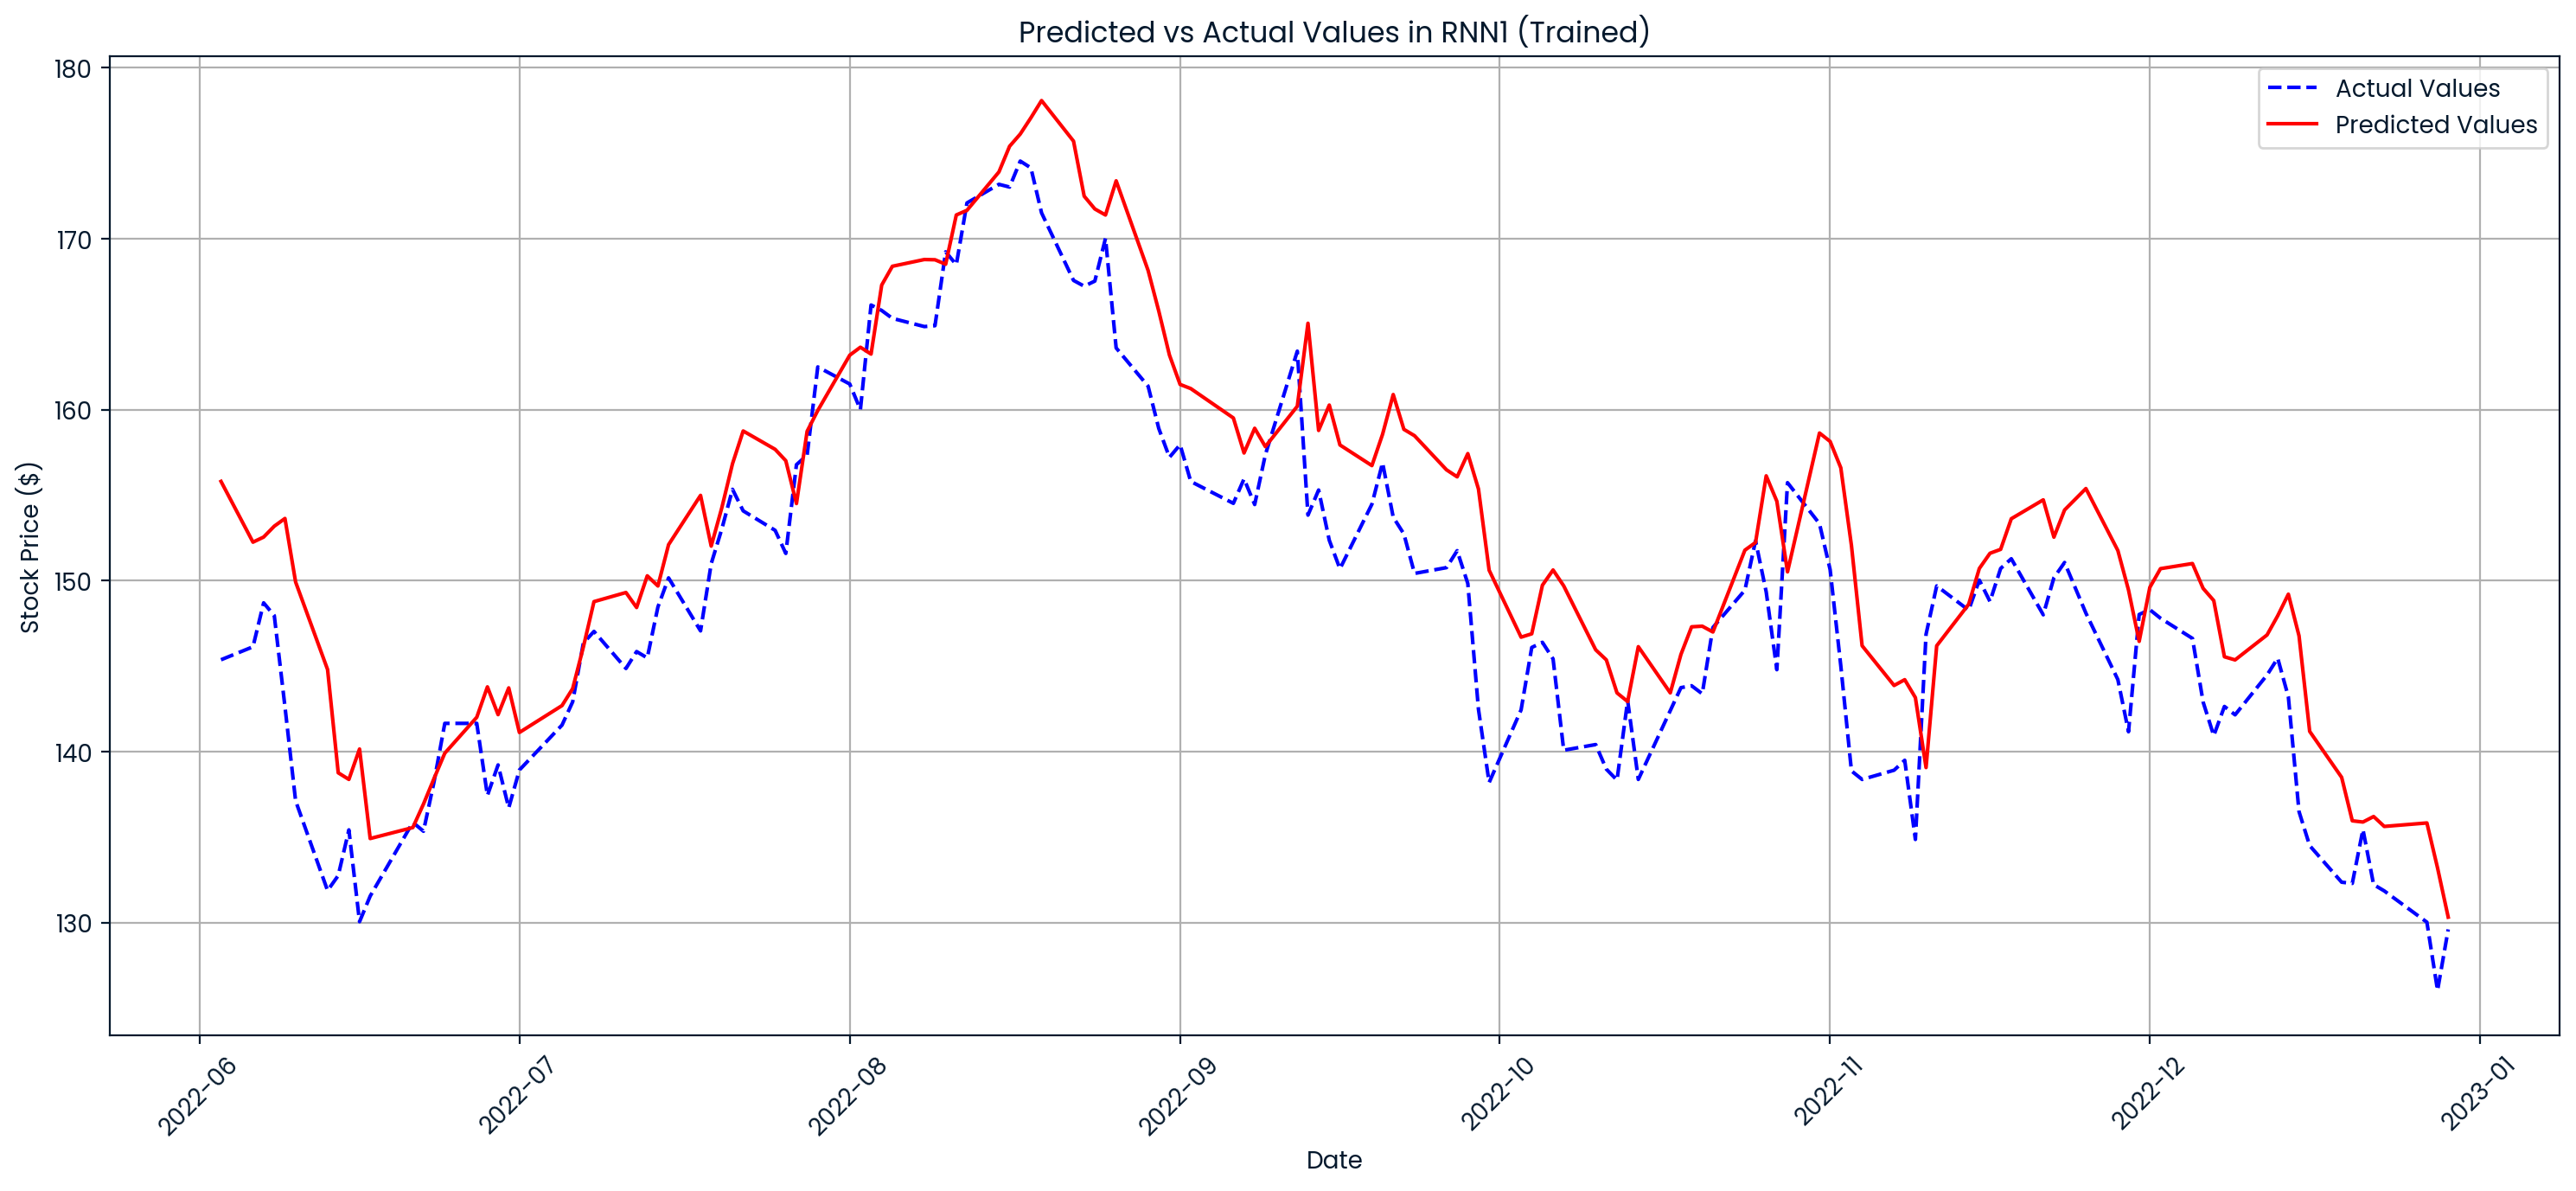


Training new RNN2 model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 30, 40)         │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 30, 40)         │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 30, 40)         │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,441 (44.69 KB)

 Trainable params: 11,441 (44.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.4803 - val_loss: 0.1437
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6064 - val_loss: 0.2391
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.6484 - val_loss: 0.0371
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3117 - val_loss: 0.0263
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3540 - val_loss: 0.1237
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4114 - val_loss: 0.1222
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4171 - val_loss: 0.0388
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2393 - val_loss: 0.0692
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2106 - val_loss: 0.1435
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1642 - val_loss: 0.0674
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1698 - val_loss: 0.0241
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1

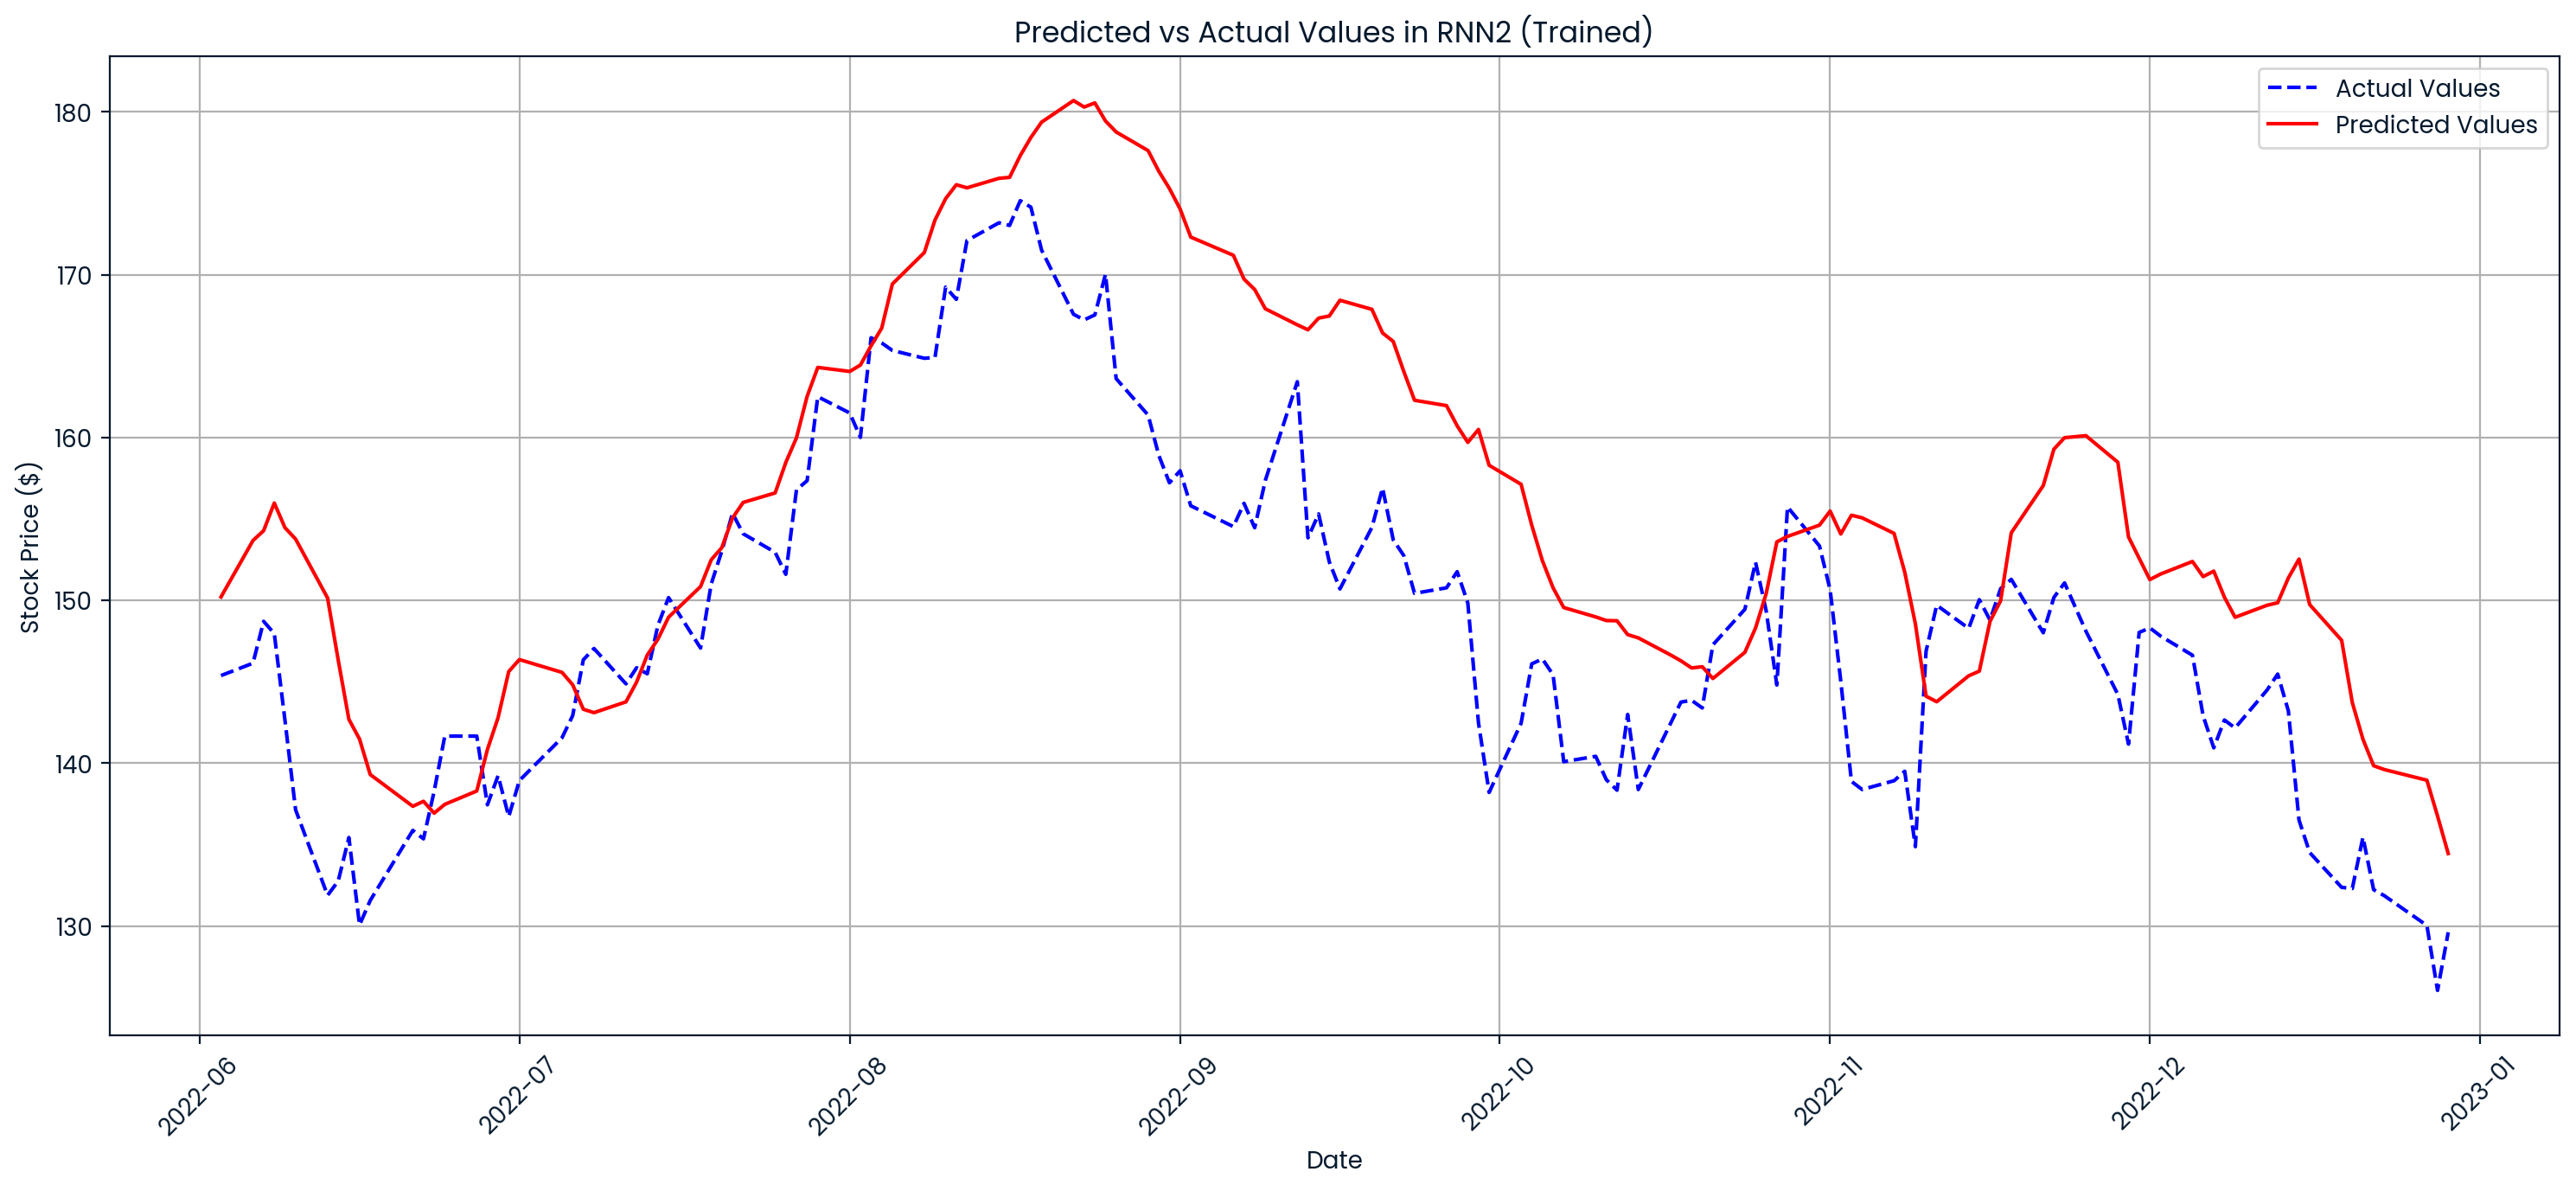


Training new GRU1 model


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 200)        │       121,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 200)            │       241,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,201 (1.39 MB)

 Trainable params: 363,201 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0101 - val_loss: 0.0014
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step

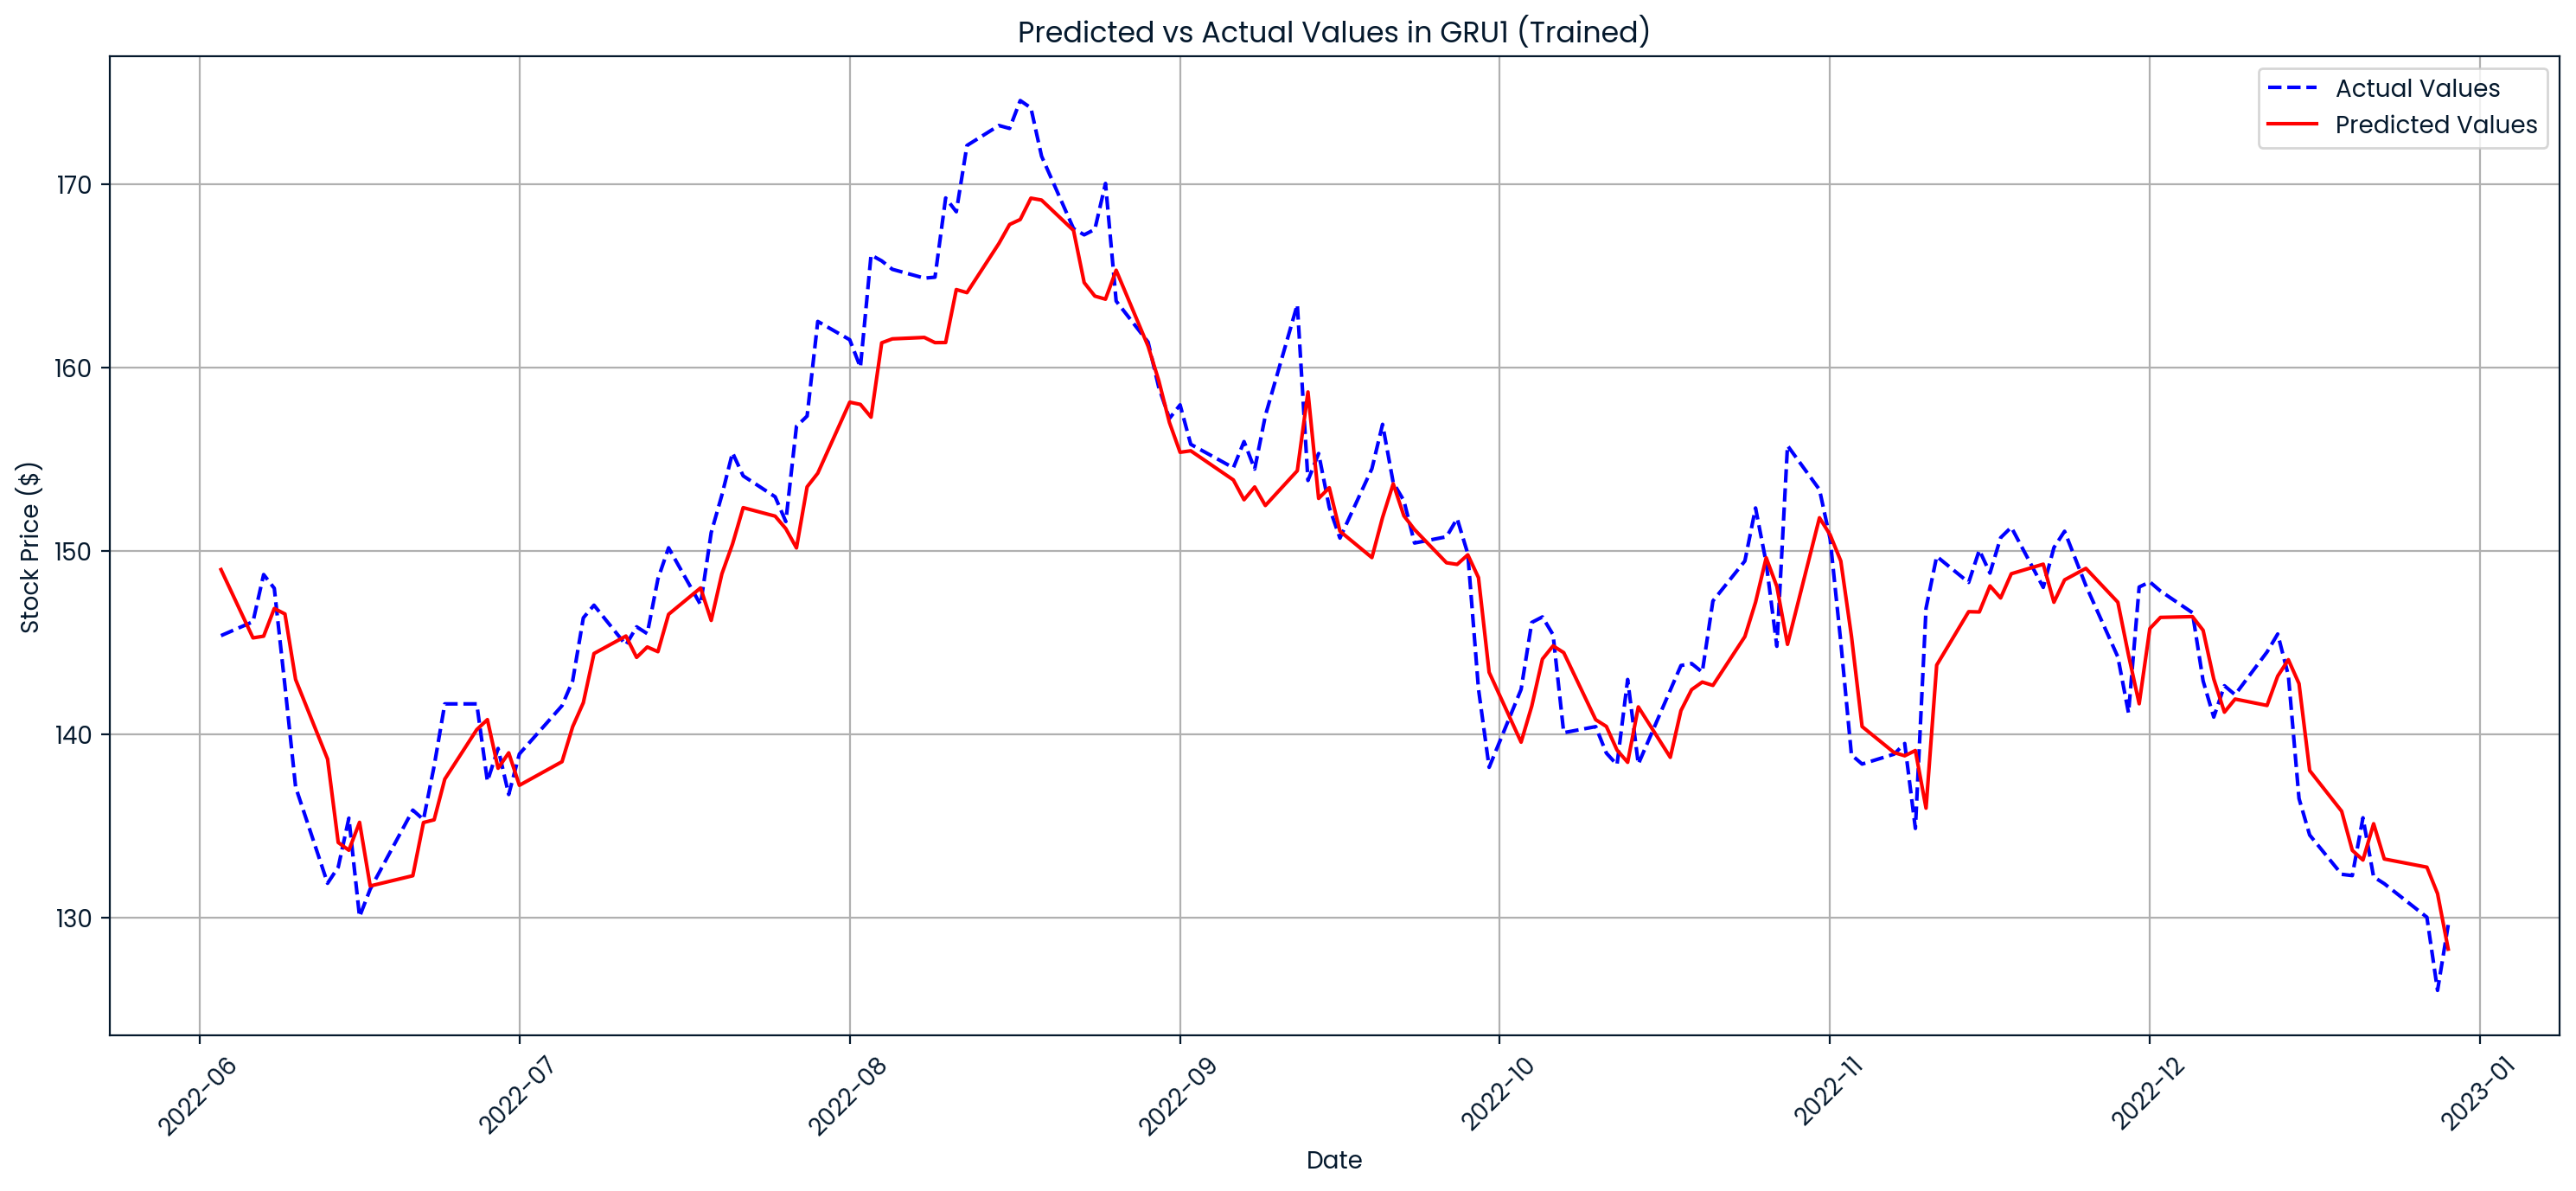


Training new GRU2 model


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 30, 40)         │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 30, 40)         │         9,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 30, 40)         │         9,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 40)             │         9,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,721 (135.63 KB)

 Trainable params: 34,721 (135.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0197 - val_loss: 0.0232
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0457 - val_loss: 0.0153
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0156 - val_loss: 0.0122
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0119 - val_loss: 0.0078
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0067 - val_loss: 0.0035
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0053 - val_loss: 0.0024
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0046 - val_loss: 0.0028
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0

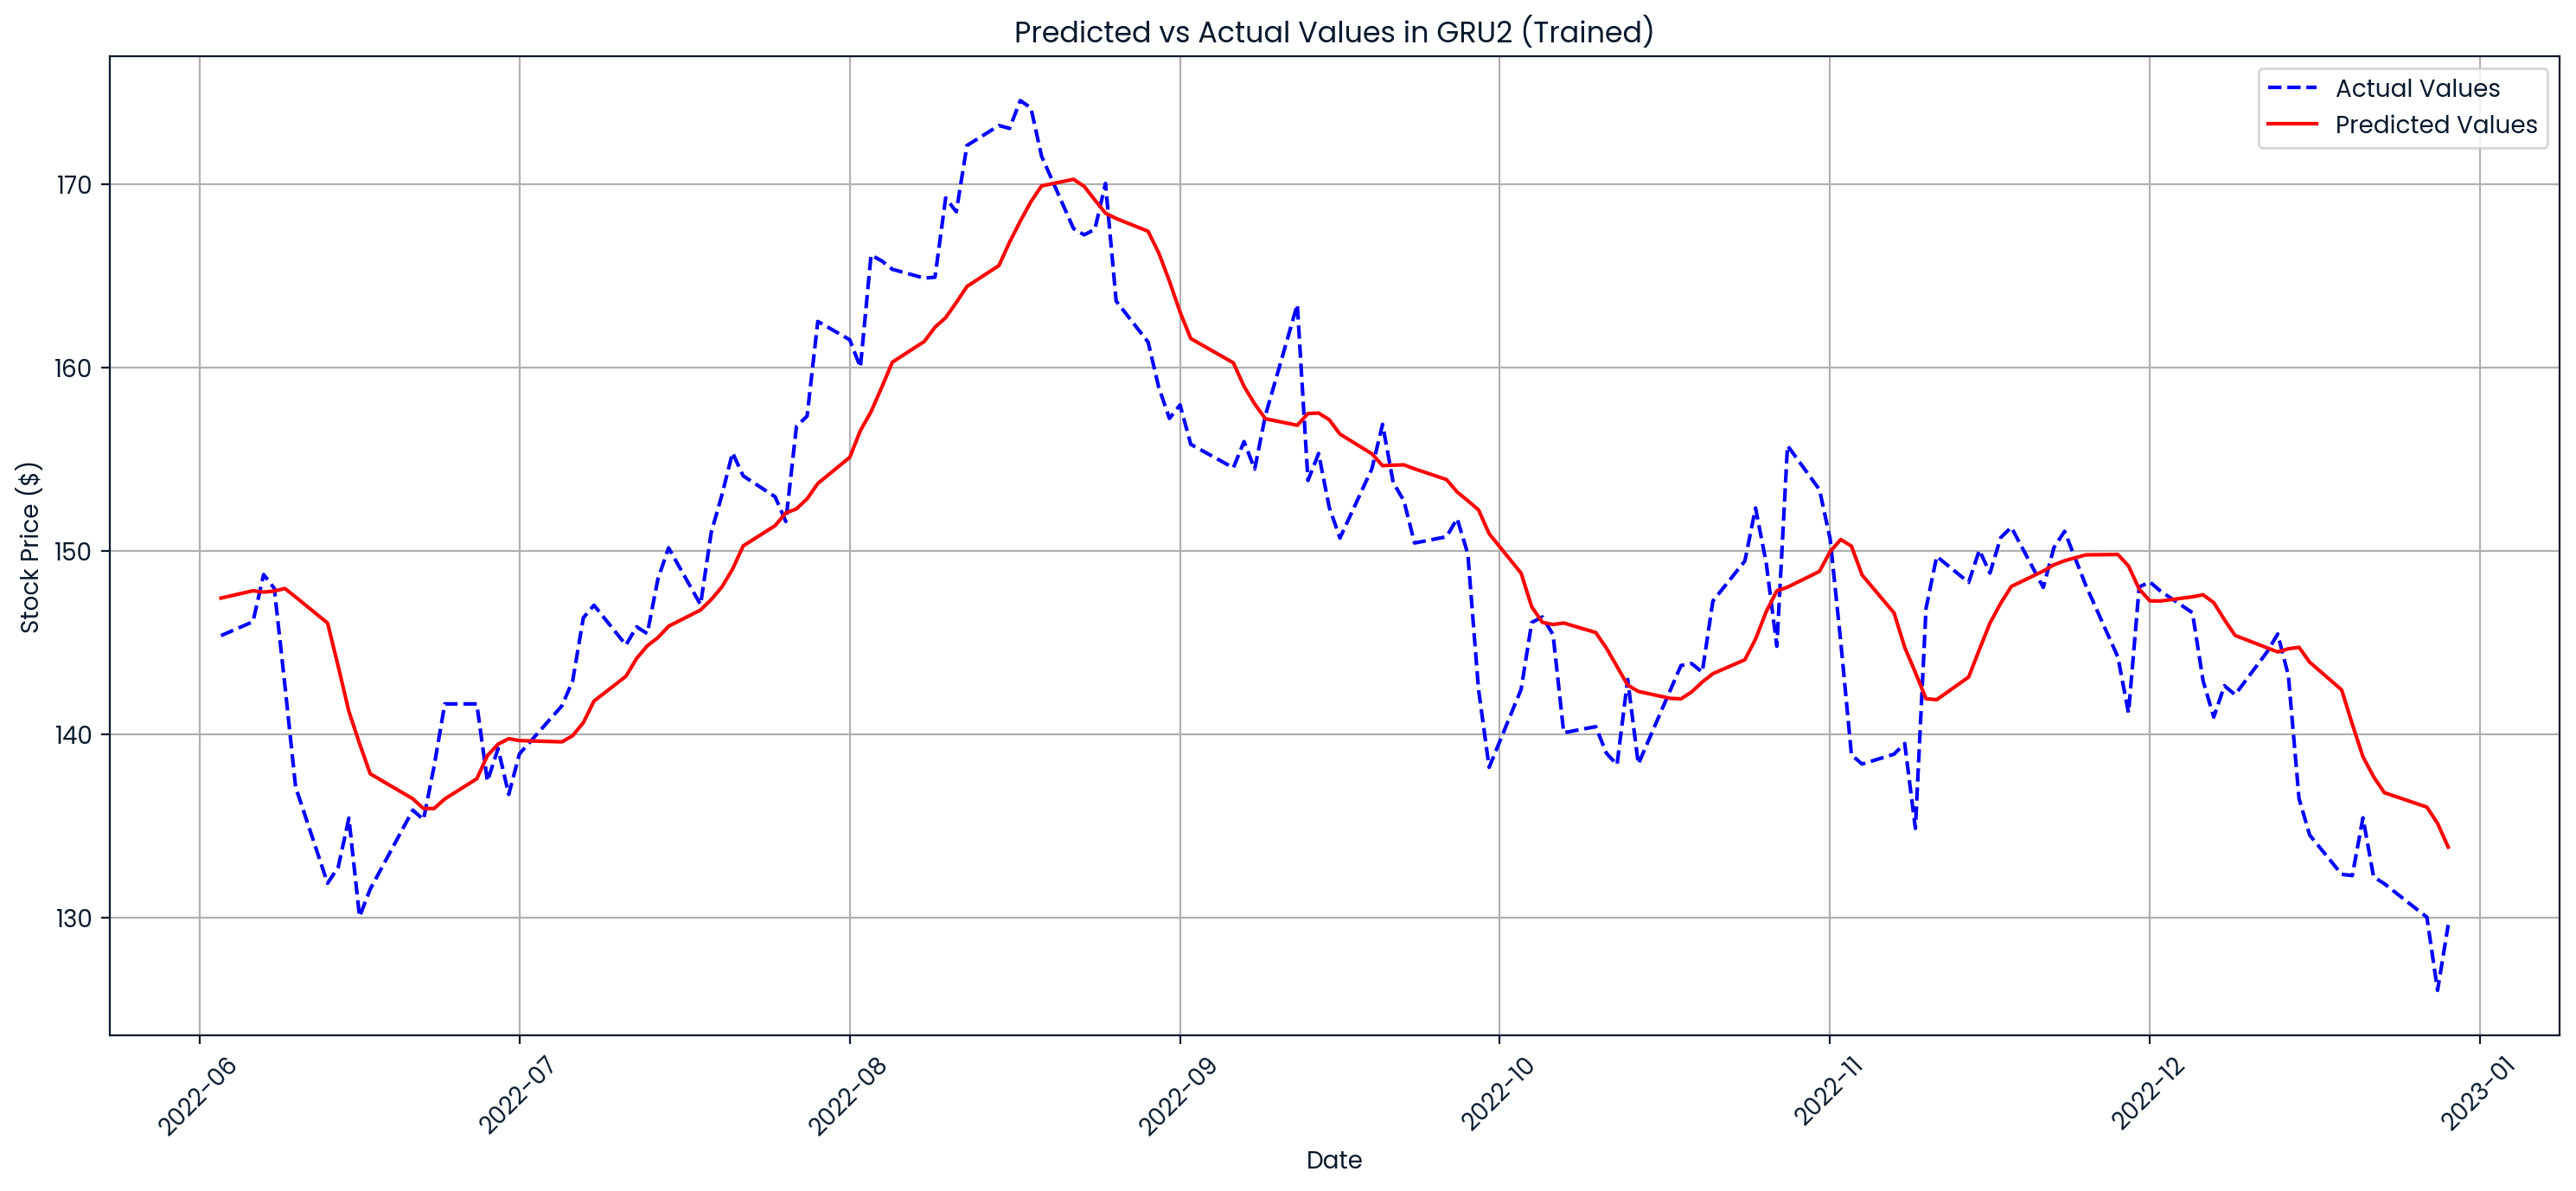


Training new LSTM1 model


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 200)        │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,601 (1.84 MB)

 Trainable params: 482,601 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 0.0178 - val_loss: 0.0038
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0109 - val_loss: 0.0041
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0067 - val_loss: 0.0027
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0068 - val_loss: 0.0027
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0055 - val_loss: 0.0024
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step

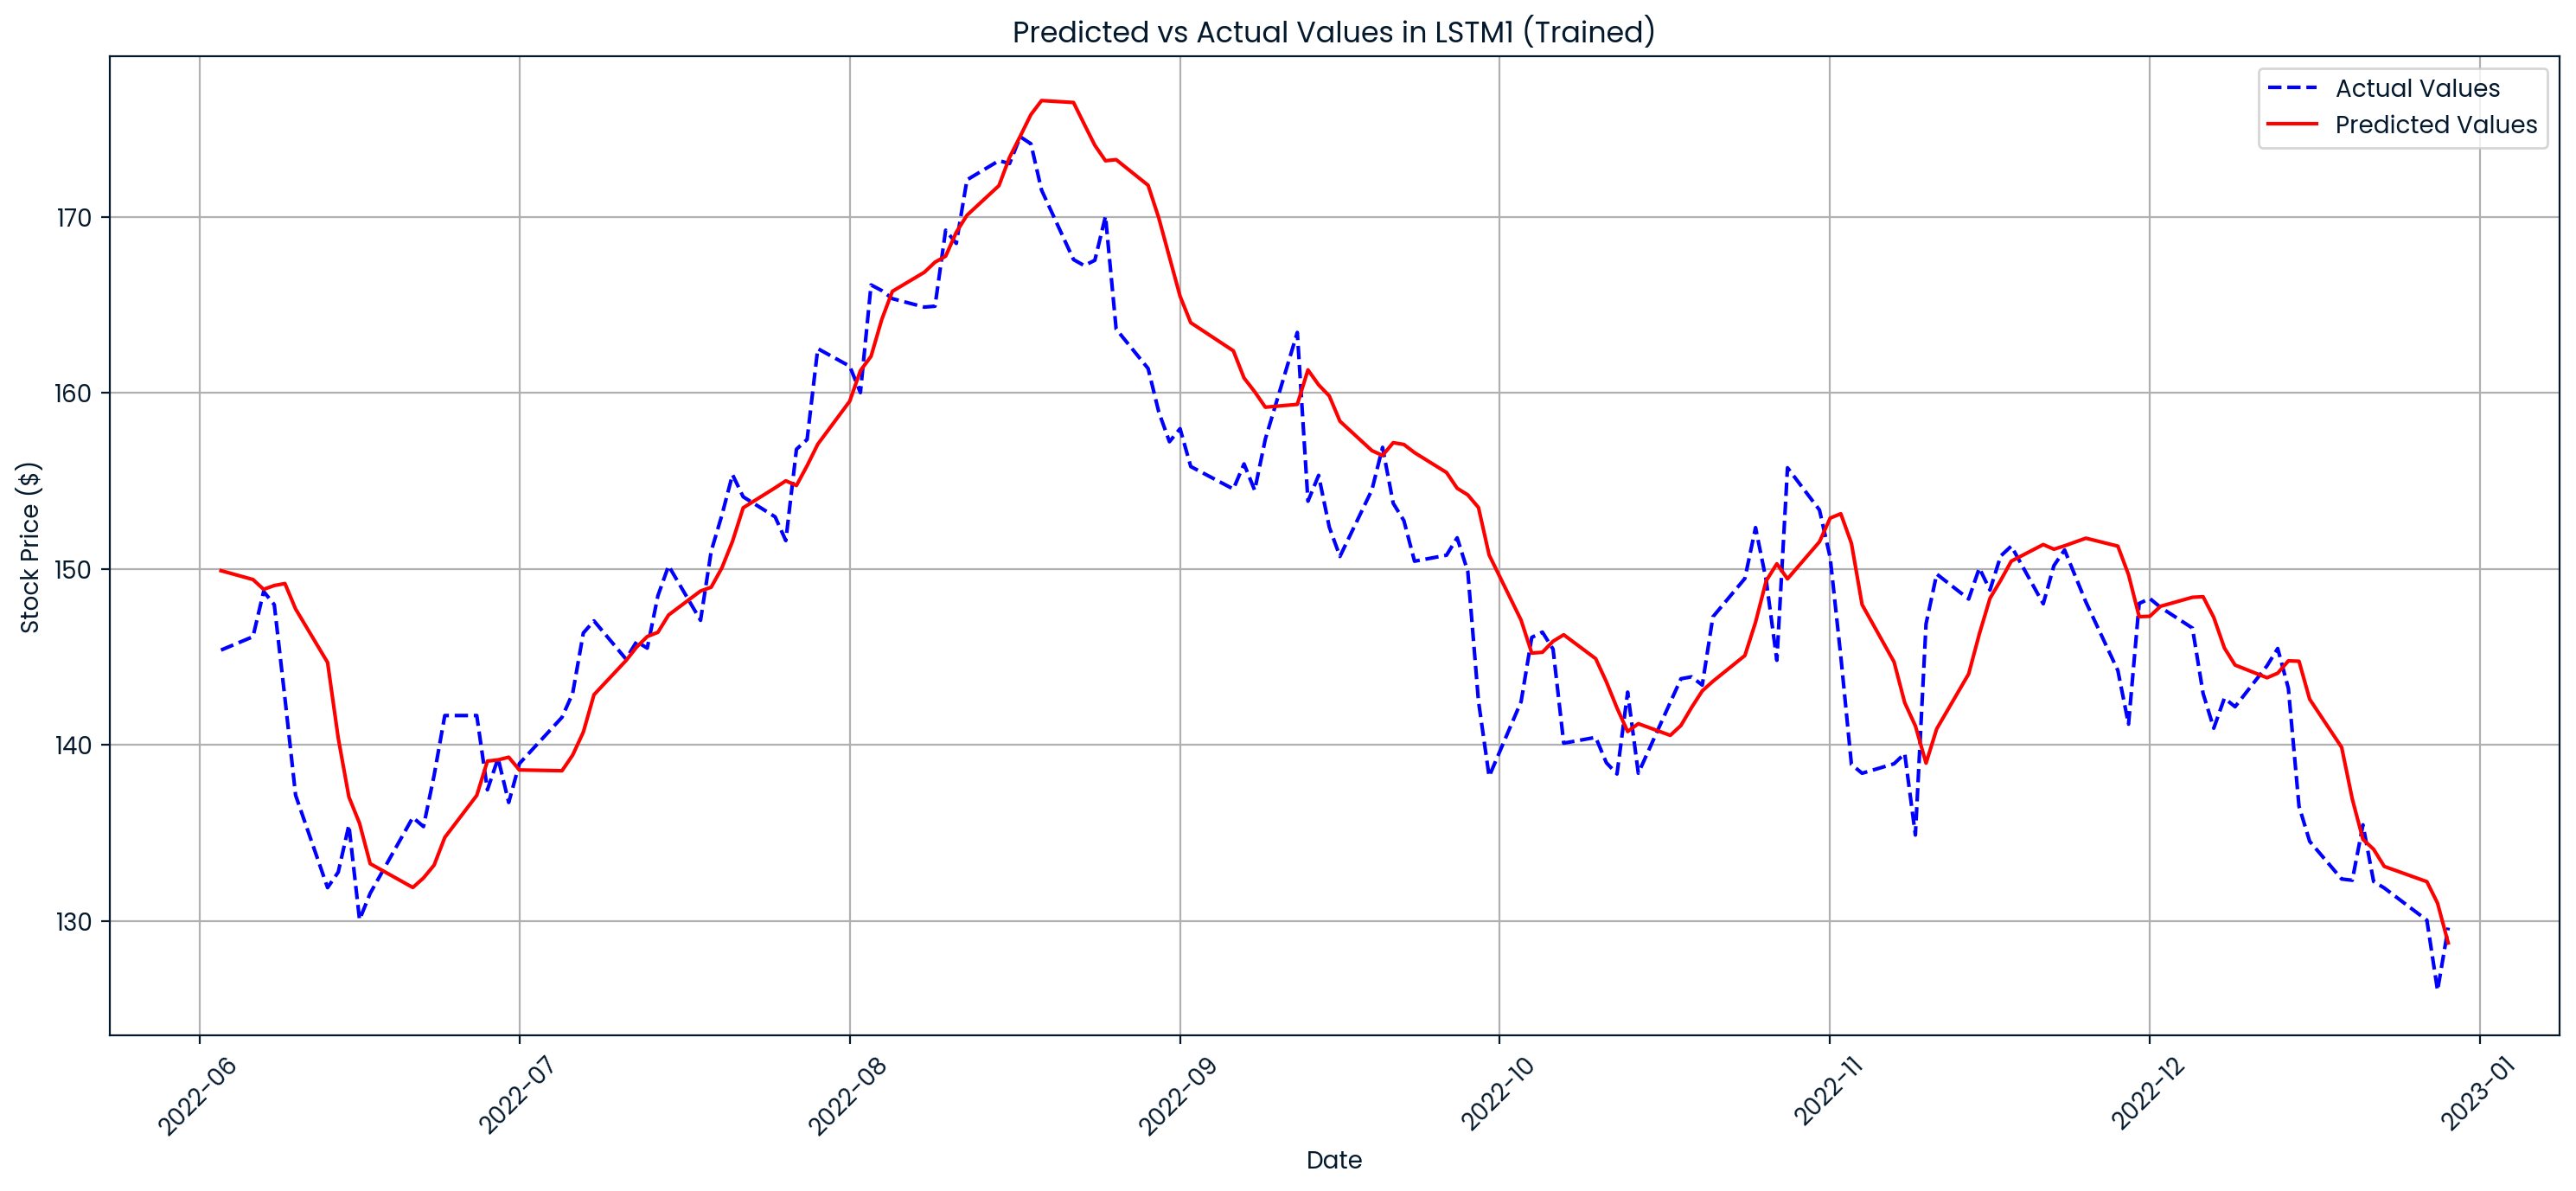


Training new LSTM2 model


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 40)         │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 30, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 40)         │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 30, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 40)         │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 30, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 40)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,641 (178.29 KB)

 Trainable params: 45,641 (178.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0348 - val_loss: 0.0421
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0537 - val_loss: 0.0163
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0268 - val_loss: 0.0419
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0311 - val_loss: 0.0364
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0265 - val_loss: 0.0158
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0083 - val_loss: 0.0139
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0101 - val_loss: 0.0099
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0076 - val_loss: 0.0095
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0069 - val_loss: 0.0137
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0082 - val_loss: 0.0153
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0082 - val_loss: 0.0103
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0

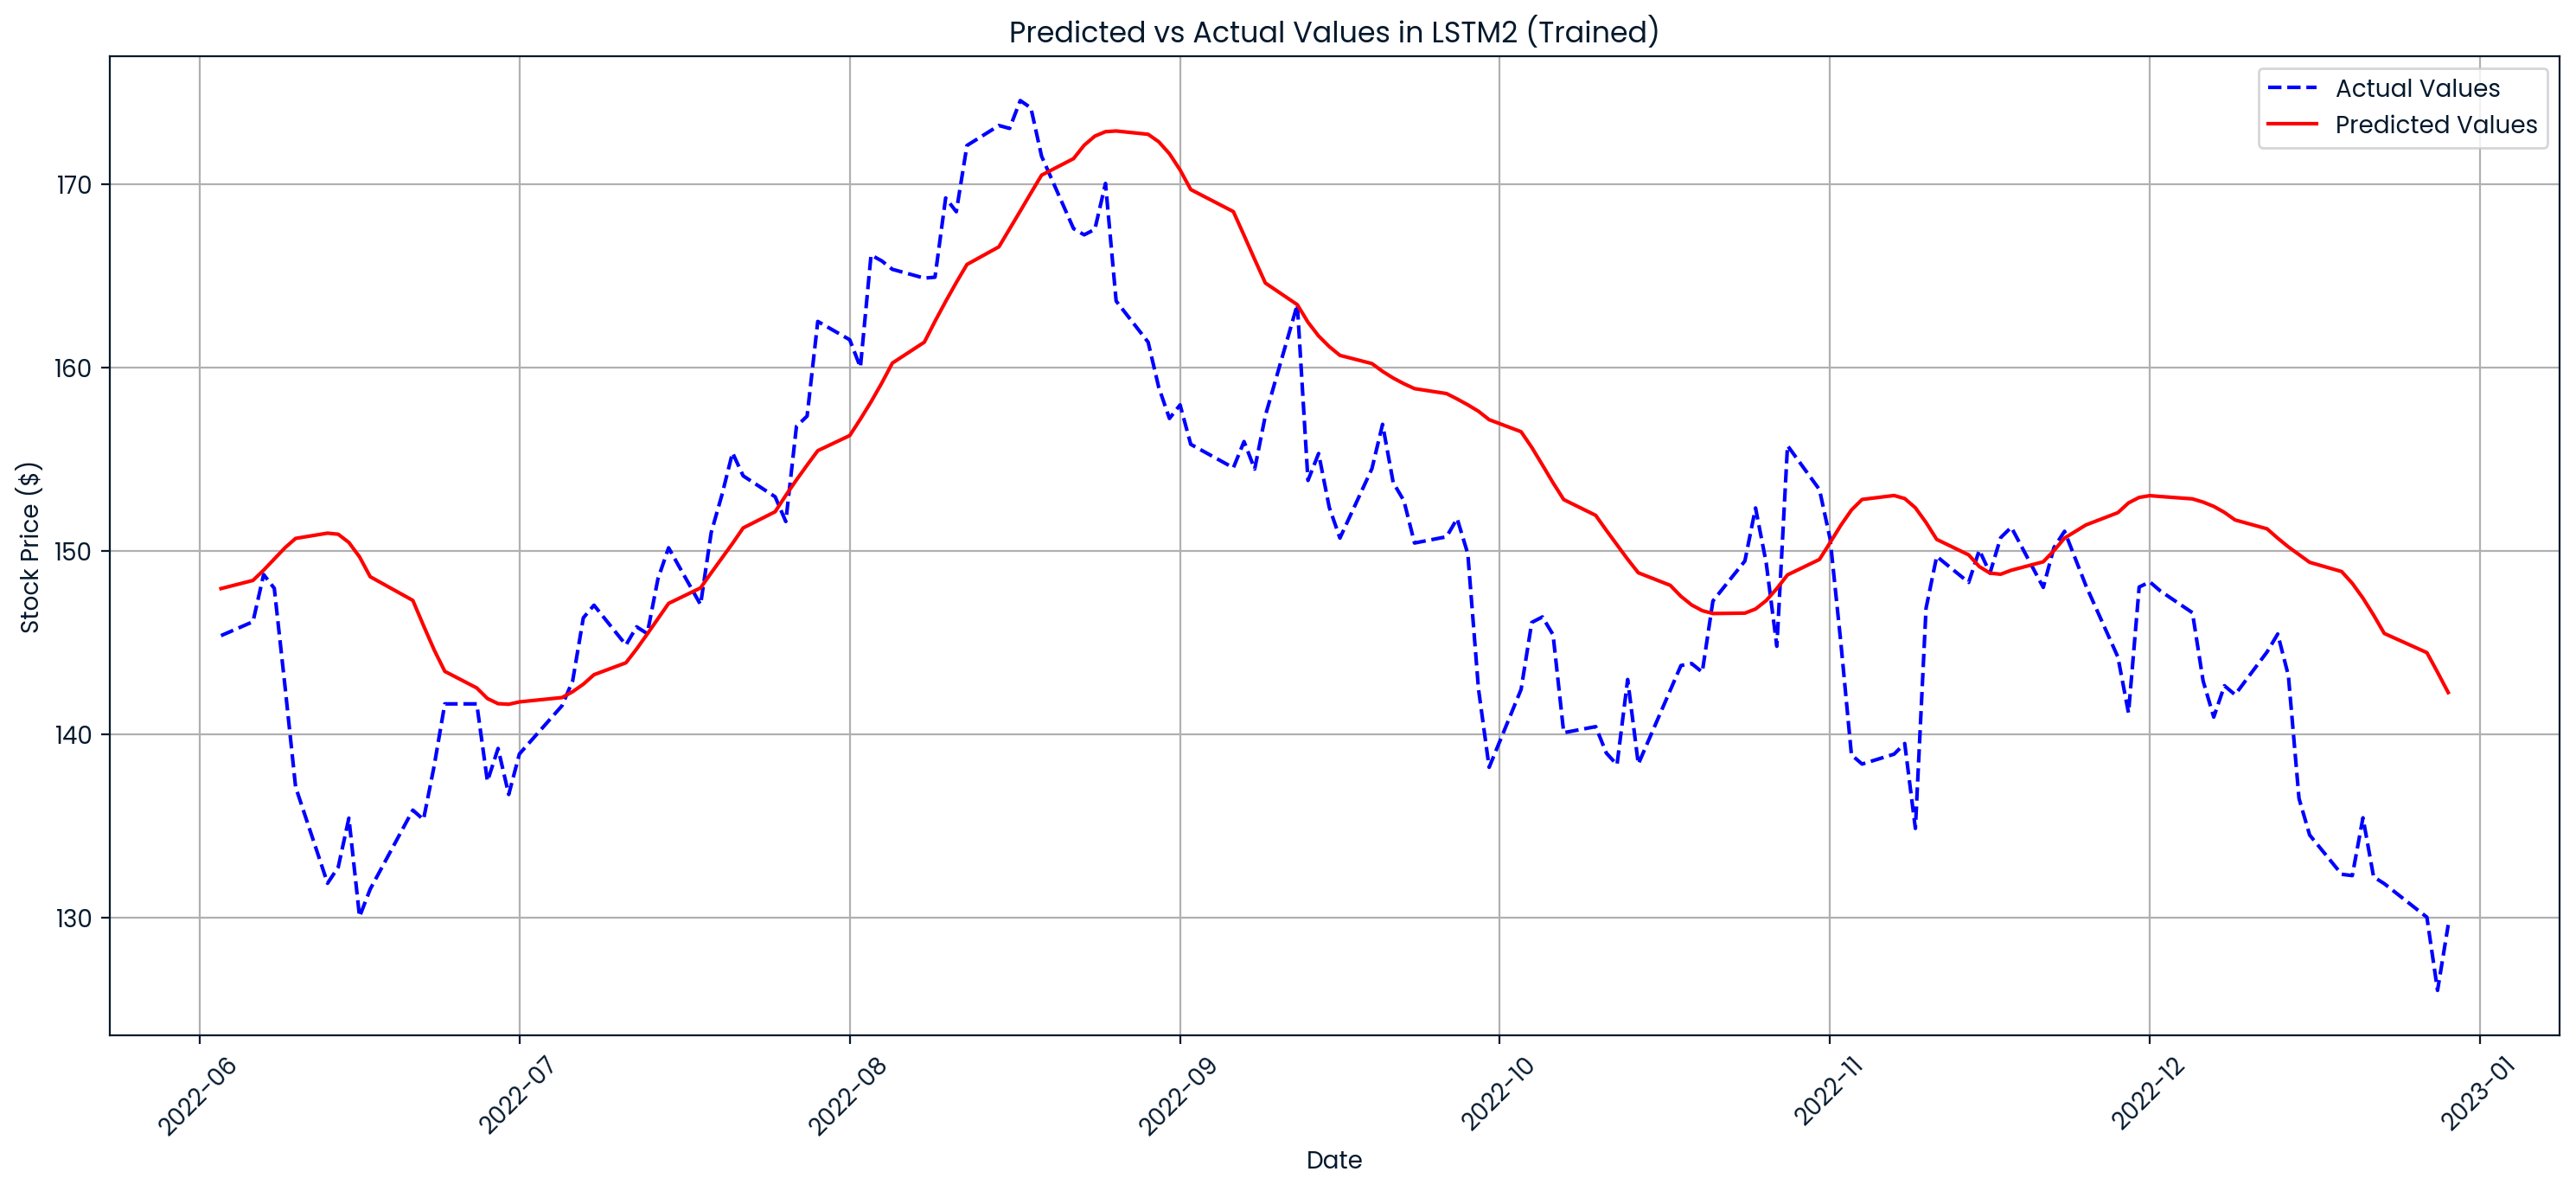


Model comparison metrics
   Model        MSE       MAE        R2
0   RNN1  30.854897  4.541342  0.733153
1   RNN2  85.771446  7.697970  0.258210
2   GRU1  14.284207  3.026314  0.876464
3   GRU2  27.181644  4.282581  0.764921
4  LSTM1  25.096923  3.953101  0.782951
5  LSTM2  75.866021  7.060189  0.343877


In [22]:
# %%
# Train and evaluate models
SHOULD_TRAIN = True  # Set to False to use saved models
metrics_df = evaluate_models(
    model_names=MODEL_NAMES,
    scalers=scalers['Close'],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    dates_test=dates_test,
    y_test_original=y_test_original,
    should_train=SHOULD_TRAIN
)

Displaying: saved_models_image_architecture/RNN1.png


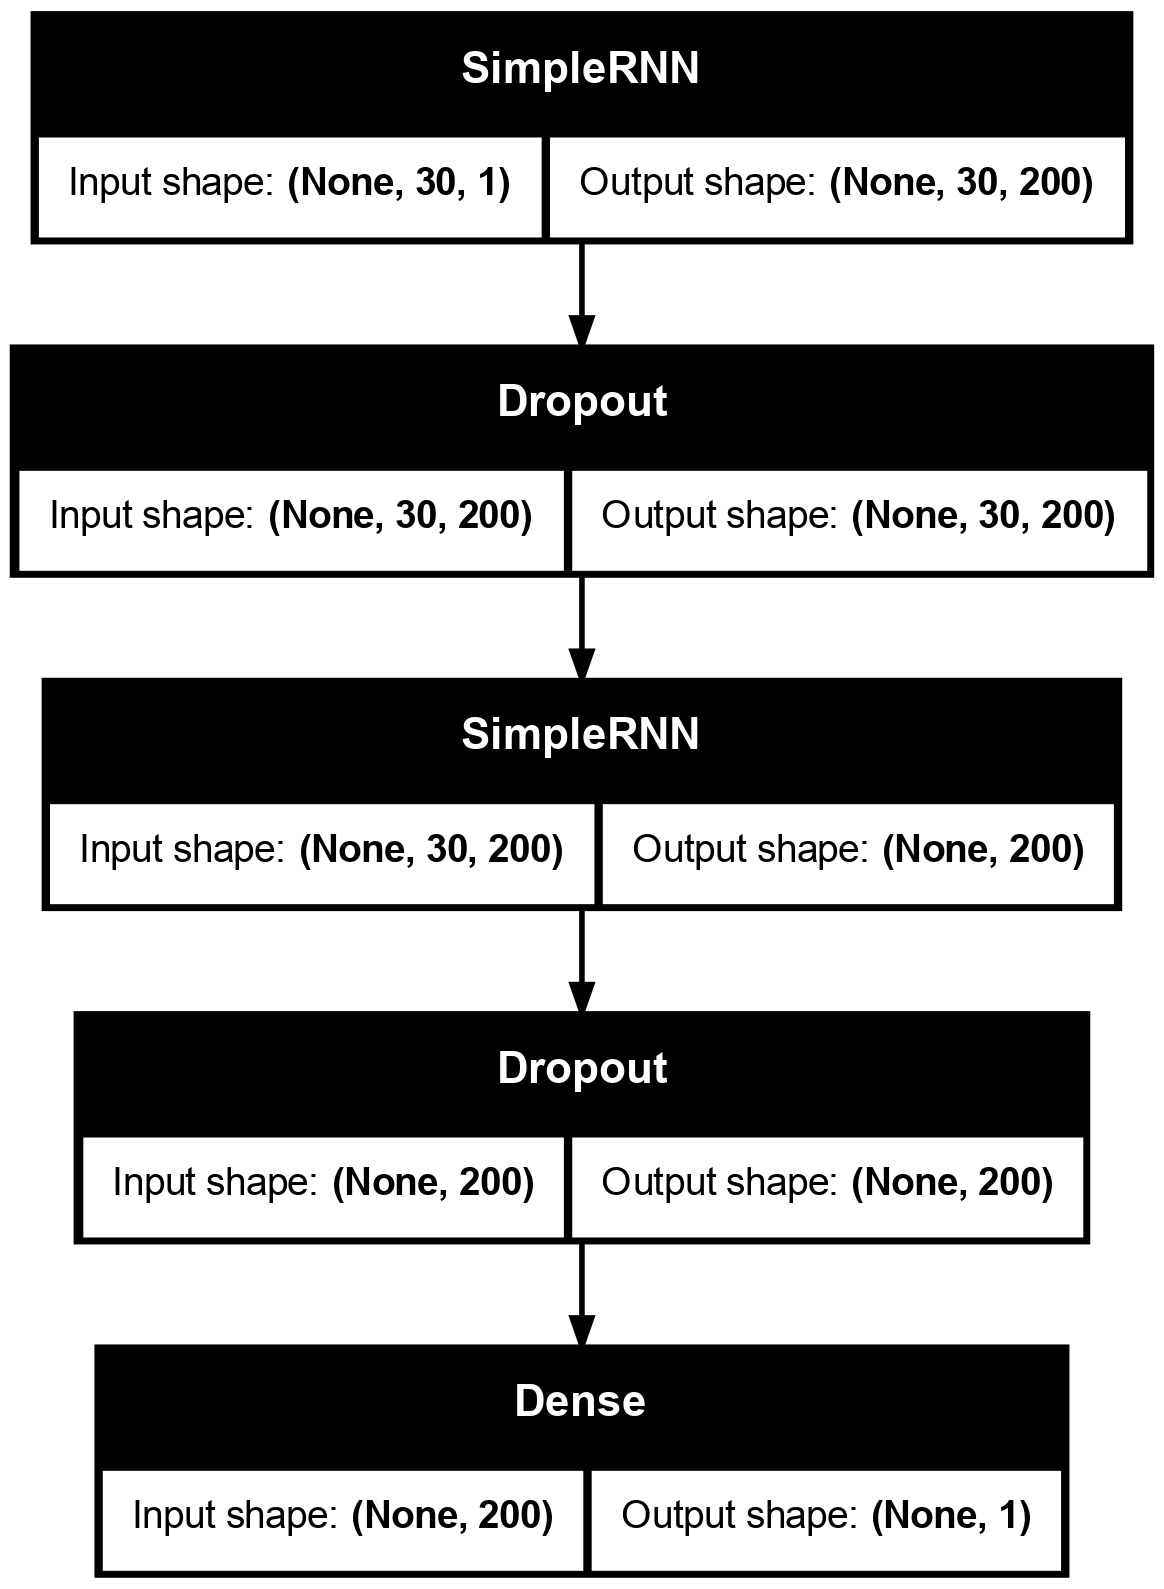

Displaying: saved_models_image_architecture/RNN2.png


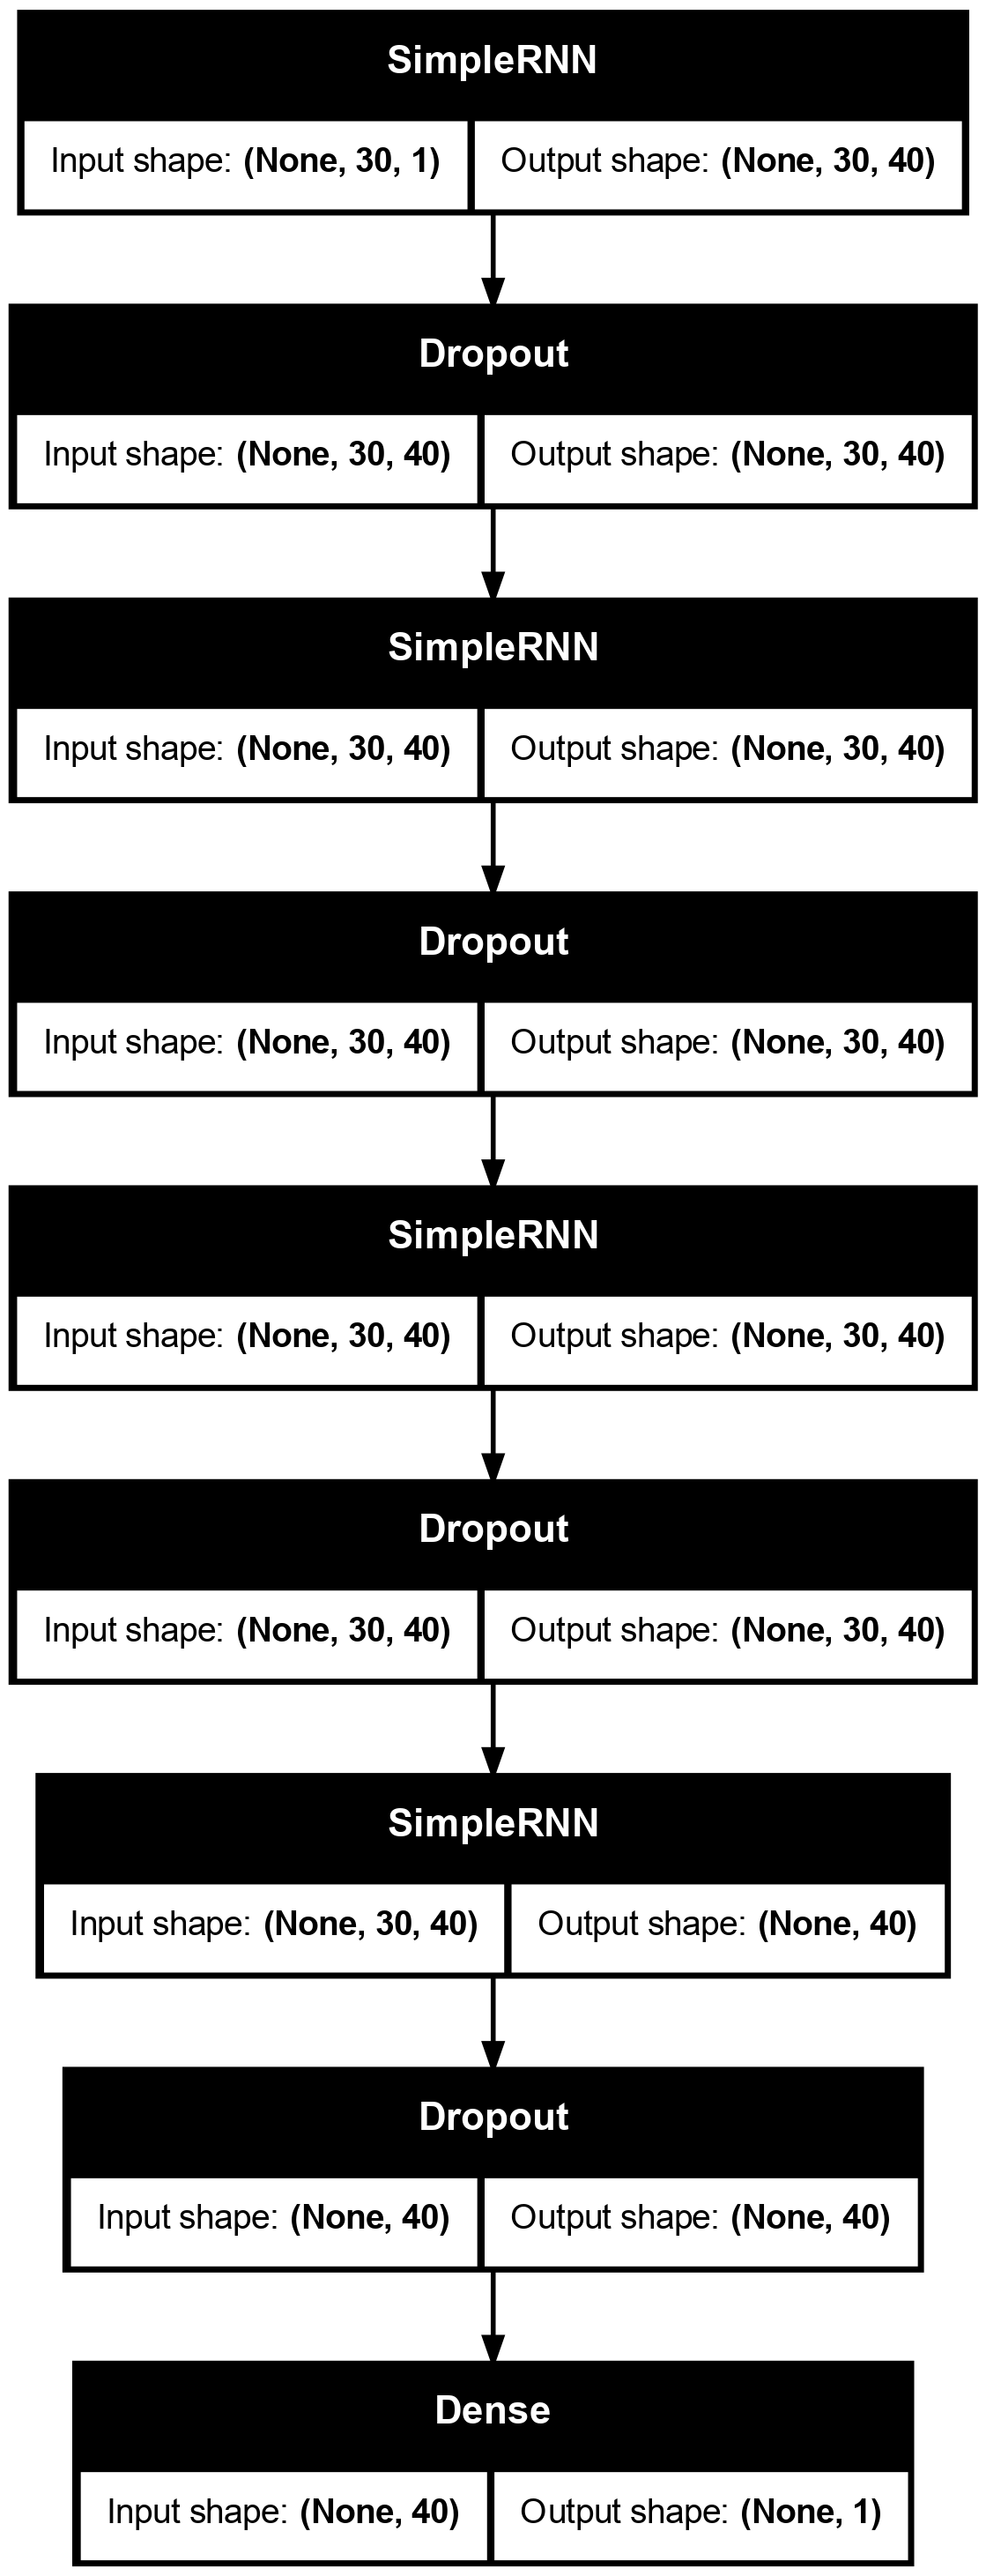

Displaying: saved_models_image_architecture/GRU1.png


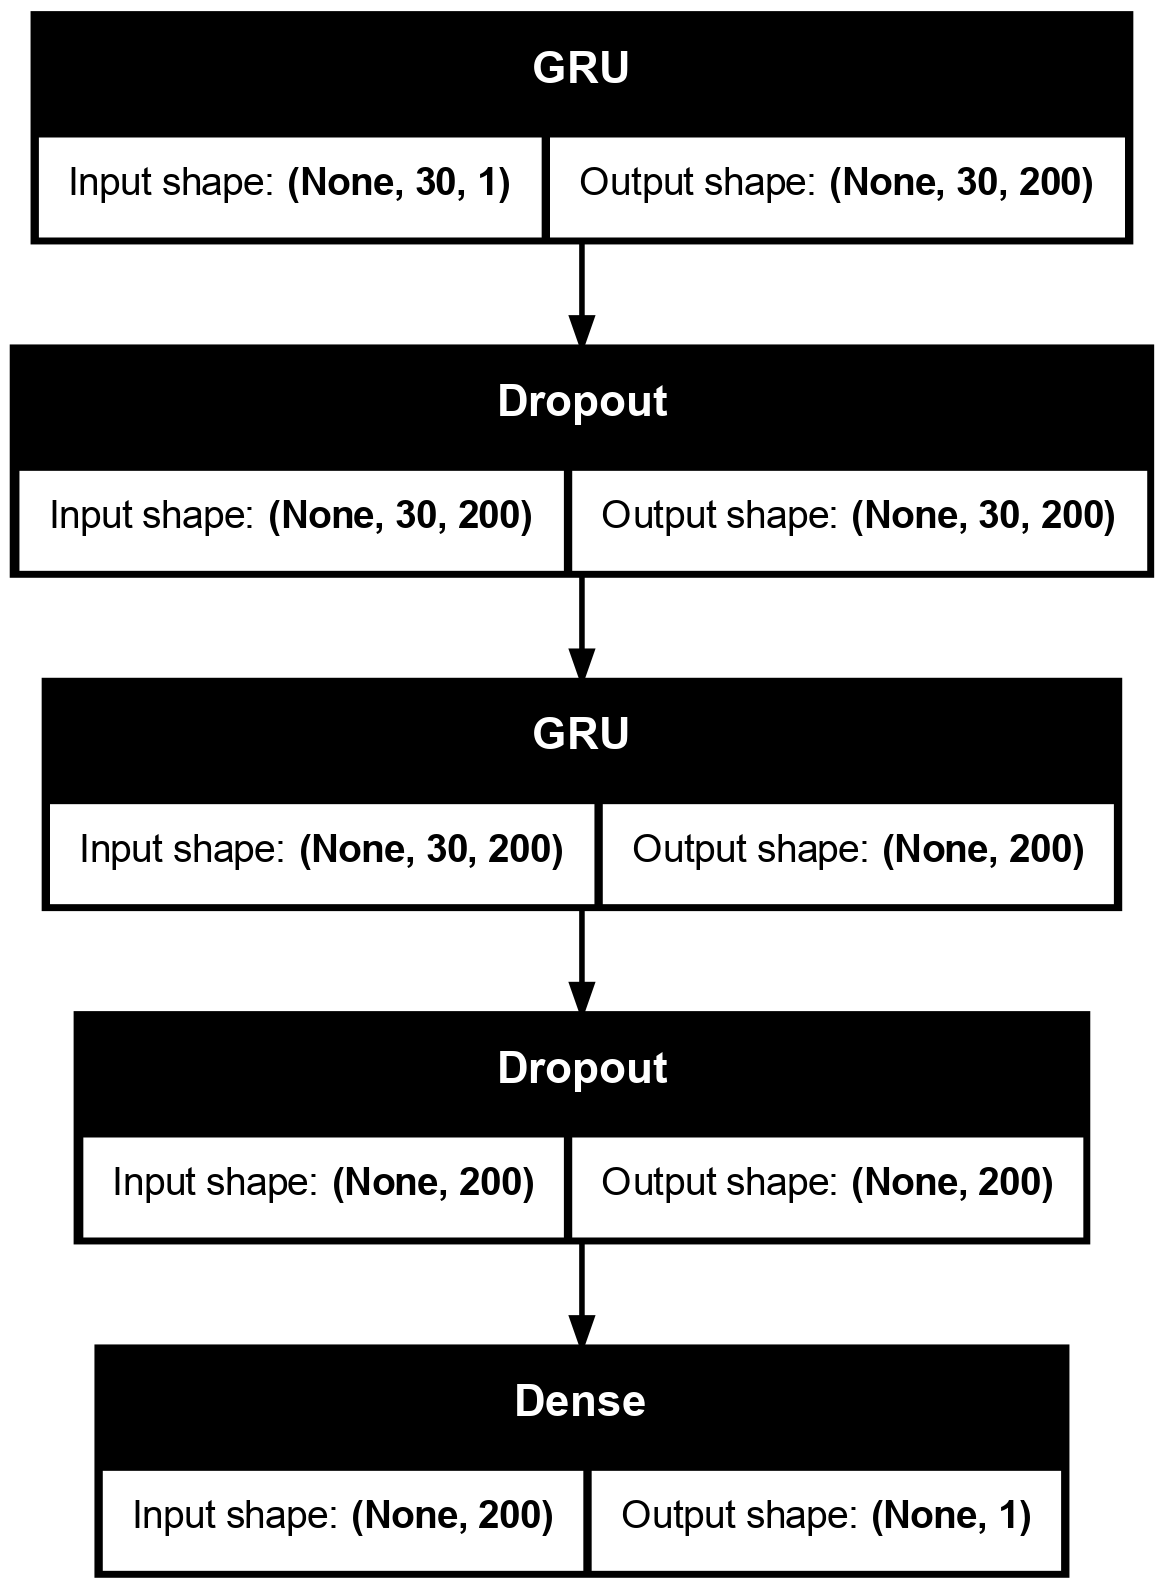

Displaying: saved_models_image_architecture/GRU2.png


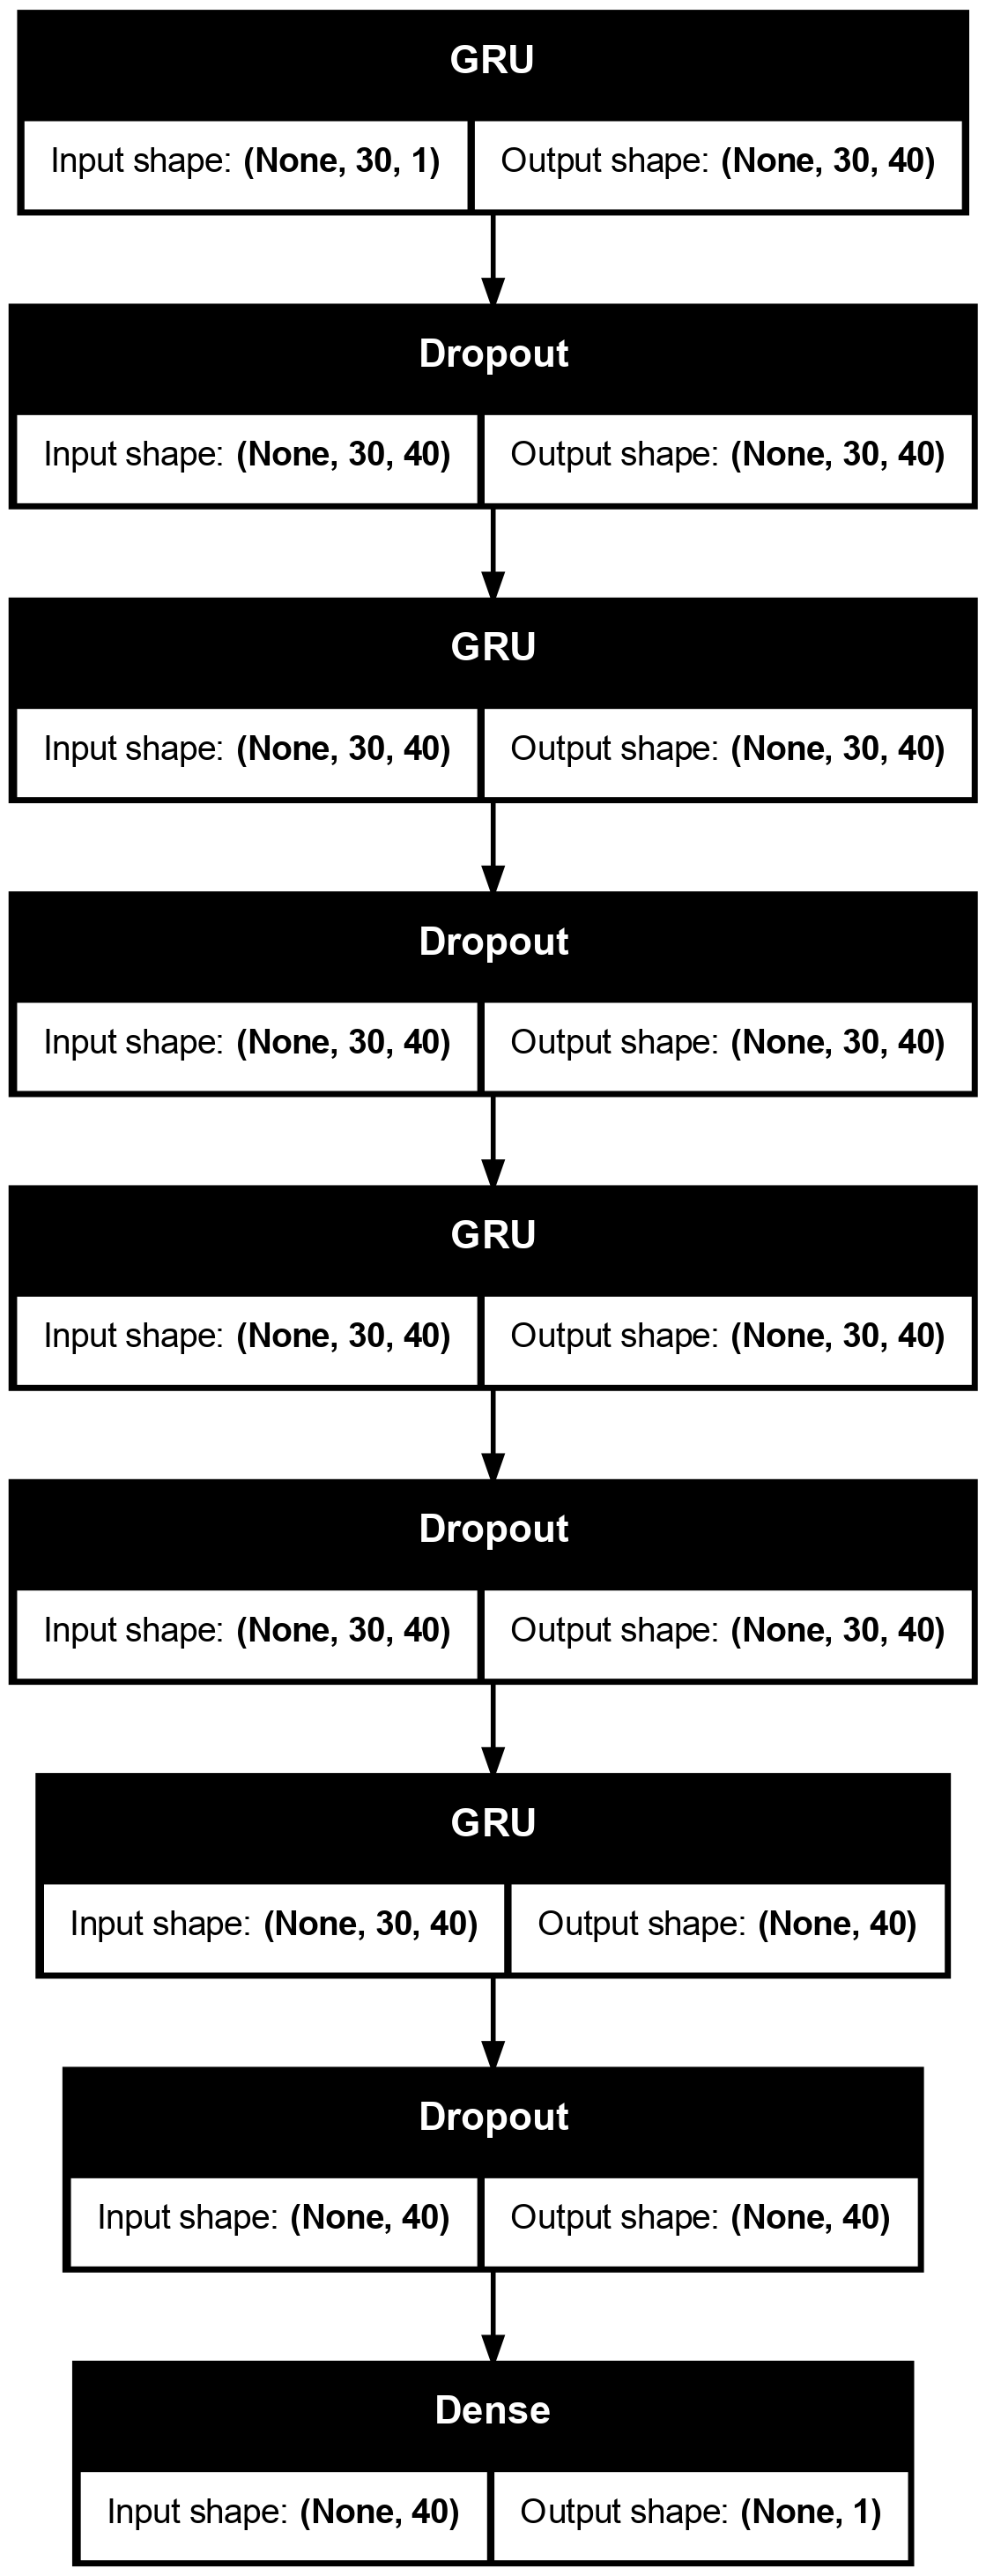

Displaying: saved_models_image_architecture/LSTM1.png


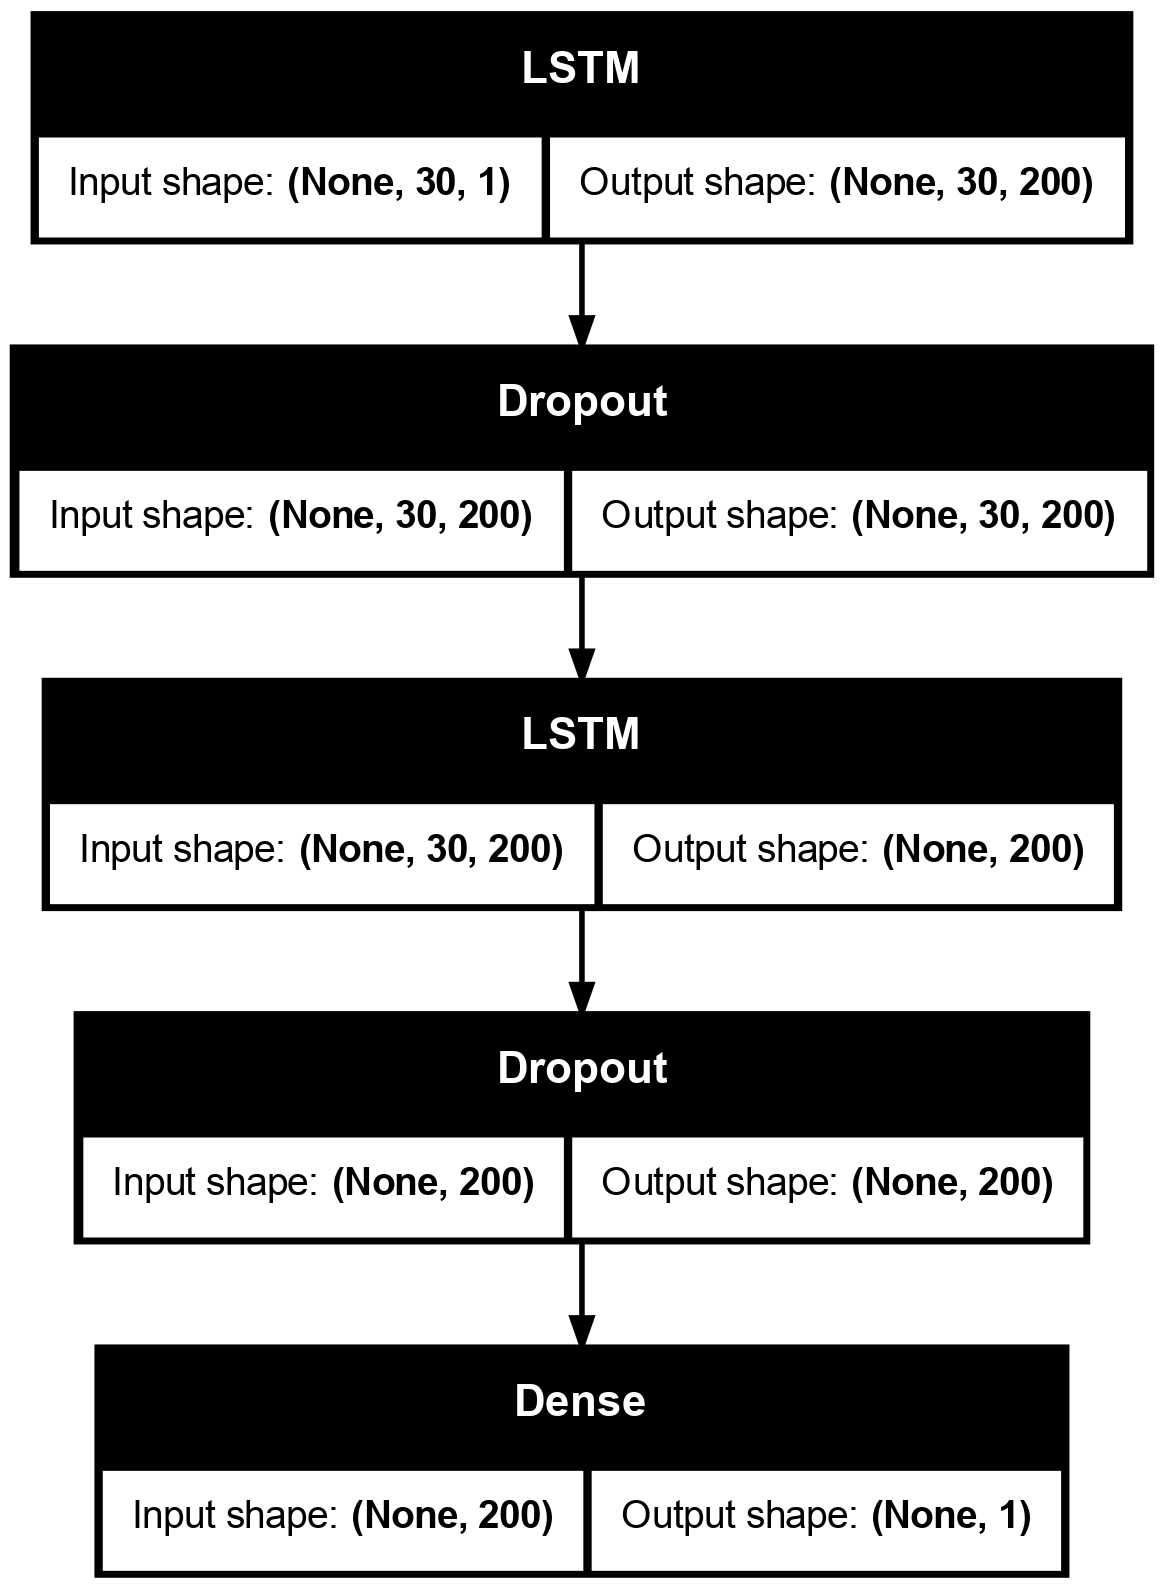

Displaying: saved_models_image_architecture/LSTM2.png


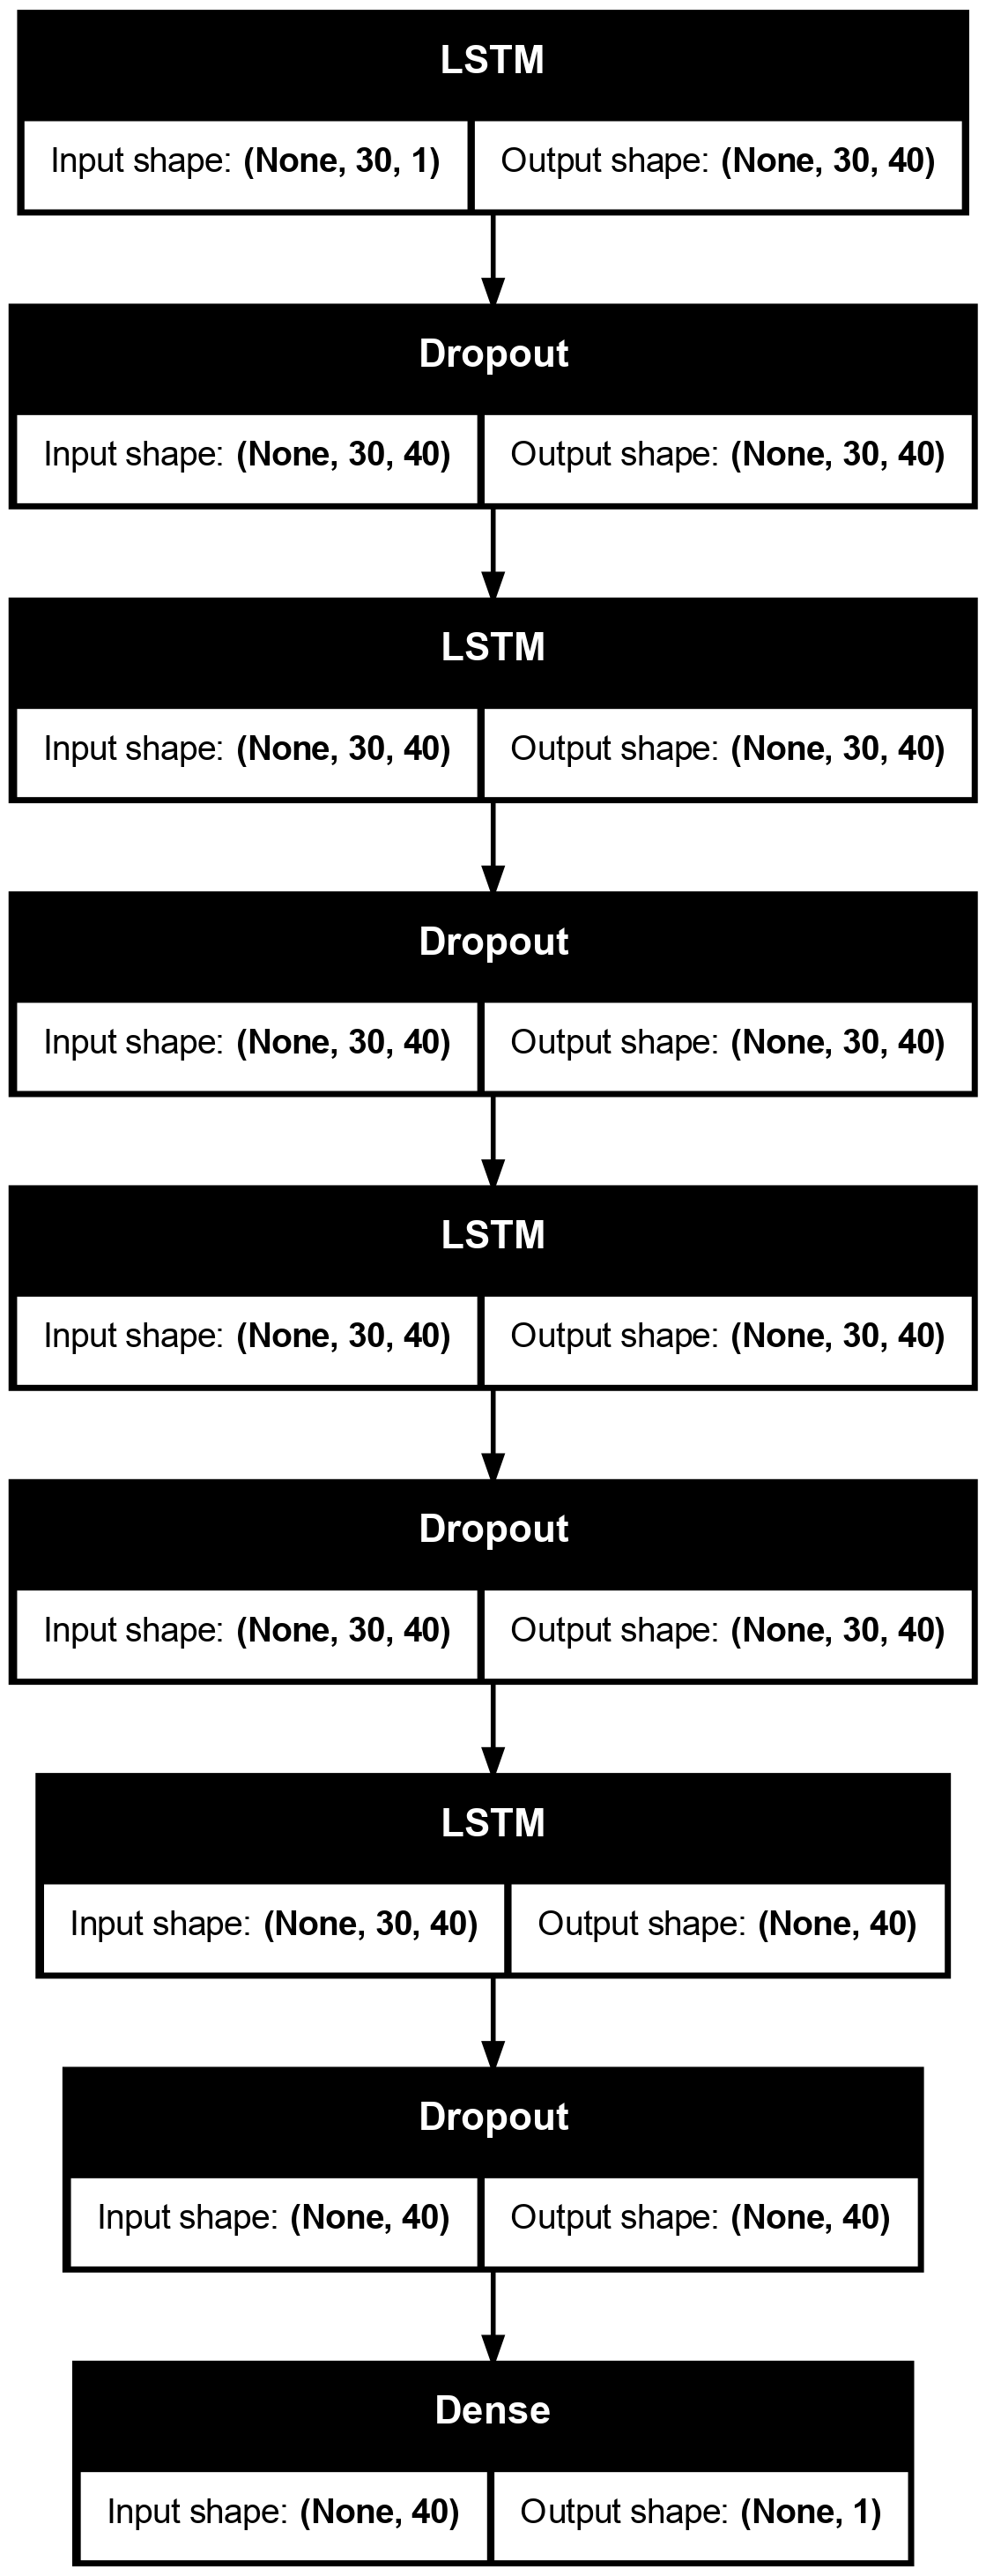

In [5]:
# Folder containing images
folder = 'saved_models_image_architecture'

# Display images for each model
def display_model_images(model_names, folder_path):
    """
    Display images for the given model names from the specified folder.

    Args:
        model_names (list): List of model names to look for.
        folder_path (str): The path to the folder containing the images.
    """
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The folder '{folder_path}' does not exist.")

    for model_name in model_names:
        # Construct the file path based on the model name
        image_path = os.path.join(folder_path, f"{model_name}.png")
        
        if os.path.exists(image_path):
            print(f"Displaying: {image_path}")
            display(Image(image_path))
        else:
            print(f"Image not found for model: {model_name} at path: {image_path}")

# Call the function to display images
try:
    display_model_images(MODEL_NAMES, folder)
except FileNotFoundError as e:
    print(e)